# Supervised linear regression machine learning model to predict the primary dendritic arm spacing

# Project Overview

During the solidification of metallic systems, the microstructure grows in treelike dendritic shape and the morphology of dendrites has a strong effect on the mechanical properties. Spacing between the dendrite arms provides information on segregation patterns and distribution of precipitates between the dendritic arms, which influences the mechanical properties. There are two well-known theoretical models that relate the primary dendritic arm spacing (PDAS) to solidification conditions, namely pulling velocity (V) and temperature gradient (G), and material properties like liquid diffusivity (D_l), the freezing range (ΔT_0), Gibbs‐Thomson coefficient (Γ), and equilibrium partition coefficient (k_e). The two models, named Hunt-Burden (HB) [1] and Kurz-Fisher (KF) [2], are different in the way the material properties are accounted:

 PDAS=2.83(k_e ΓΔT_0 D_l )^0.25 G^(-0.5) V^(-0.25)  		HB model 
 
PDAS=4.3(ΓΔT_0 D_l/k_e )^0.25 G^(-0.5) V^(-0.25)	.	KF model

Despite the previous attempts, there are still important issues to develop a predictive model of PDAS for a wide range of solidification rates. In rapid solidification cases, such as in laser additive manufacturing of materials, the analytical relations and models for PDAS have significant deviations from computational predications and experimental data for the same solidification condition [3]. In this project we want to develop more reliable analytical models for prediction of PDAS in a wide range of solidification rates. For this, a supervised linear regression machine learning model will be used to produce a new relation between PDAS and the solidification rate (pulling velocity and temperature gradient in the model) that works for different material systems. 


# Data Wrangling

### 1. Sourcing and loading

#### 1a. Import relevant libraries 

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
import seaborn as sns # For all our visualization needs.
import statsmodels.api as sm # Second library for linear regression model based on OLS
from statsmodels.graphics.api import abline_plot # What does this do? Find out and type here.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error # acess performance.
from sklearn.model_selection import train_test_split,cross_validate,KFold,cross_val_score #split data in training and testing dataset
from sklearn import linear_model, preprocessing # linear regression models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV#,GridSearchCV
from sklearn.model_selection import GridSearchCV

import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
from sklearn import *
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


#### 1b. Load the data

We have generated the data, so we know they are almost clean. However, I perfowm the typical data wrangling steps use dto idensify if there are any problems with the data files

In [2]:
# Load the data. 
df=pd.read_csv("../Data/PDAS_all.csv")
df_exp=pd.read_csv("../Data/PDAS-experiment.csv")

#### 1c. Exploring the data

In [3]:
# Check out its appearance. 
df.head(n=5)

V           G        Mat_HB        Mat_KF          PDAS
0  0.01  10000000.0  2.020000e-14  2.570000e-13  2.468570e-06
1  0.02  10000000.0  2.020000e-14  2.570000e-13  2.160000e-06
2  0.03  10000000.0  2.020000e-14  2.570000e-13  1.080000e-06
3  0.04  10000000.0  2.020000e-14  2.570000e-13  9.257140e-07
4  0.05  10000000.0  2.020000e-14  2.570000e-13  8.100000e-07

In [4]:
# overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V       250 non-null    float64
 1   G       250 non-null    float64
 2   Mat_HB  250 non-null    float64
 3   Mat_KF  250 non-null    float64
 4   PDAS    250 non-null    float64
dtypes: float64(5)
memory usage: 9.9 KB


Because I have already generated the data I know the data are all in correct format and all the rows have correct values.
However this shows all columns have correct data type. They also do not have a missing value

In [5]:
df.isna().any()

V         False
G         False
Mat_HB    False
Mat_KF    False
PDAS      False
dtype: bool

In [6]:
df_exp.isna().any()

V         False
G         False
Mat_HB    False
Mat_KF    False
PDAS      False
Alloy     False
dtype: bool

As expected, we do not have any NULL values

In [7]:
df.duplicated().any()

False

In [8]:
df['Mat_HB'].nunique()

7

The data set have overall data for 7 alloys. for each alloy the PDAS is calculated based on different values of V and G.

In [9]:
print(df["Mat_HB"].unique())

[2.02e-14 3.37e-14 3.51e-14 5.85e-15 2.30e-15 4.33e-15 5.11e-15]


In [10]:
# We need a new column showing the alloy name
# we know Mat_HB of 2.02e-14 3.37e-14 3.51e-14 5.85e-15 2.30e-15 4.33e-15 5.11e-15 belonds to Ti-3.4%Ni, Ti-7.1%Ni, Ti-10.6%Ni, 
# Mg-9 at% Al, Al-6 at%Cu, Al-8 at%Cu, and Al-10 at%Cu

conditions=[np.logical_and(df["Mat_HB"].gt(2.01e-14),df["Mat_HB"].lt(2.03e-14)),
            np.logical_and(df["Mat_HB"].gt(3.36e-14),df["Mat_HB"].lt(3.38e-14)),
            np.logical_and(df["Mat_HB"].gt(3.50e-14),df["Mat_HB"].lt(3.52e-14)),
            np.logical_and(df["Mat_HB"].gt(5.84e-15),df["Mat_HB"].lt(5.86e-15)),
            np.logical_and(df["Mat_HB"].gt(2.29e-15),df["Mat_HB"].lt(2.31e-15)),
            np.logical_and(df["Mat_HB"].gt(4.32e-15),df["Mat_HB"].lt(4.34e-15)),
            np.logical_and(df["Mat_HB"].gt(5.10e-15),df["Mat_HB"].lt(5.12e-15))]
outputs=["Ti-3.4 at% Ni","Ti-7.1 at% Ni","Ti-10.7 at% Ni","Mg- 9 at% Al","Al-6 at% Cu","Al-8 at% Cu","Al-10 at% Cu"]
df["Alloy"]=pd.Series(np.select(conditions,outputs,"alloy"))


In [11]:
# OUR equation will have the following format PDAS=A (V)^alpha (G)^beta (matprop)^gamma. To make this easier to change to
# a regression model, 
# we will first deside the dependent variable as PDAS and then We will take ln of all the columns and add it to a new column
#and move forward with that
df.head()

V           G        Mat_HB        Mat_KF          PDAS          Alloy
0  0.01  10000000.0  2.020000e-14  2.570000e-13  2.468570e-06  Ti-3.4 at% Ni
1  0.02  10000000.0  2.020000e-14  2.570000e-13  2.160000e-06  Ti-3.4 at% Ni
2  0.03  10000000.0  2.020000e-14  2.570000e-13  1.080000e-06  Ti-3.4 at% Ni
3  0.04  10000000.0  2.020000e-14  2.570000e-13  9.257140e-07  Ti-3.4 at% Ni
4  0.05  10000000.0  2.020000e-14  2.570000e-13  8.100000e-07  Ti-3.4 at% Ni

In [12]:
# Get a basic statistical summary of the dependent variable 
#PDAS is our fixed dependent variable
df["PDAS"].describe()

count    2.500000e+02
mean     2.573232e-06
std      6.532639e-06
min      1.322670e-07
25%      4.926000e-07
50%      8.134800e-07
75%      1.470000e-06
max      6.294750e-05
Name: PDAS, dtype: float64

# Exploratory Data Analysis and Feature Engineering

Now that we've chosen PDAS as our dependent variable for regression analysis, we can begin by plotting the pairwise relationships in the dataset, to check out how our variables relate to one another.
if we plot the pairwise relationshi for V,G,matprop_HB,matprop_KF we do not see any specific relationship, but plotting the logaritmic in base e it will have useful information

In [13]:
# We do not have any missing or NA data points or any outliers. However, We have discussed in the summary that in order to use 
# the linear regression model we should modify our variables and use their logarithmic values in the ML model

df["ln(PDAS)"]=np.log(df["PDAS"])
df["ln(V)"]=np.log(df["V"])
df["ln(G)"]=np.log(df["G"])
df[r"ln($A_{HT}$)"]=np.log(df["Mat_HB"])
df[r"ln($A_{KF}$)"]=np.log(df["Mat_KF"])


In [14]:
V_list=df['V'].to_list()
G_list=df['G'].to_list()
KF_list=df['Mat_KF'].to_list()
HT_list=df['Mat_HB'].to_list()
PDAS_list=df['PDAS'].to_list()
print(min(PDAS_list),max(PDAS_list))

1.32267e-07 6.29475e-05


In [15]:
df_ln=df.drop(["PDAS","V","G","Mat_HB","Mat_KF"],axis=1)

In [16]:
df_ln.head()

Alloy   ln(PDAS)     ln(V)      ln(G)  ln($A_{HT}$)  ln($A_{KF}$)
0  Ti-3.4 at% Ni -12.911872 -4.605170  16.118096    -31.533094      -28.9897
1  Ti-3.4 at% Ni -13.045402 -3.912023  16.118096    -31.533094      -28.9897
2  Ti-3.4 at% Ni -13.738550 -3.506558  16.118096    -31.533094      -28.9897
3  Ti-3.4 at% Ni -13.892701 -3.218876  16.118096    -31.533094      -28.9897
4  Ti-3.4 at% Ni -14.026232 -2.995732  16.118096    -31.533094      -28.9897

In [17]:
# Call the .corr() method on the wine dataset 
df_ln.corr(method='pearson',numeric_only=True)

ln(PDAS)     ln(V)     ln(G)  ln($A_{HT}$)  ln($A_{KF}$)
ln(PDAS)      1.000000 -0.817739 -0.180500      0.502430      0.411290
ln(V)        -0.817739  1.000000 -0.042756     -0.133750     -0.087158
ln(G)        -0.180500 -0.042756  1.000000      0.098657      0.242190
ln($A_{HT}$)  0.502430 -0.133750  0.098657      1.000000      0.962904
ln($A_{KF}$)  0.411290 -0.087158  0.242190      0.962904      1.000000

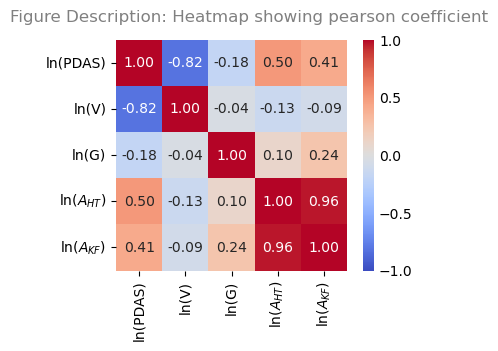

In [20]:
# Make a heatmap of the data 
plt.figure(figsize=[4,3])
#mask = np.triu(np.ones_like(df_ln.corr(method='pearson',numeric_only=True), dtype=bool))
#mask=np.array([[ False  ,True , True , True , True],
# [False , True , True , True , True],
# [False, False , True,  True , True],
# [False, False ,False , True , True],
# [False, False, False ,False,  False]])
plt.suptitle('Figure Description: Heatmap showing pearson coefficient',c="grey") # or plt.suptitle('Main title')

ax=sns.heatmap(df_ln.corr(method='pearson',numeric_only=True),annot=True, fmt='.2f',square=True,vmin=-1,vmax=1, cmap='coolwarm') #,mask=mask
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])  # Set the position of ticks
cbar.ax.tick_params(size=0)  # Set the size of the tick lines to 0

plt.savefig("../Figure_new/Heatmap.jpeg",dpi=1200,bbox_inches='tight')

We find a strong correlation (negative) between PDAS_ln and V_ln, also PDAS_ln and G_ln. both HB and KF material properties also have strong but positive effects on PDAS_ln

In [21]:
color=sns.color_palette("husl", 7).as_hex()
print(color[0])

#f77189


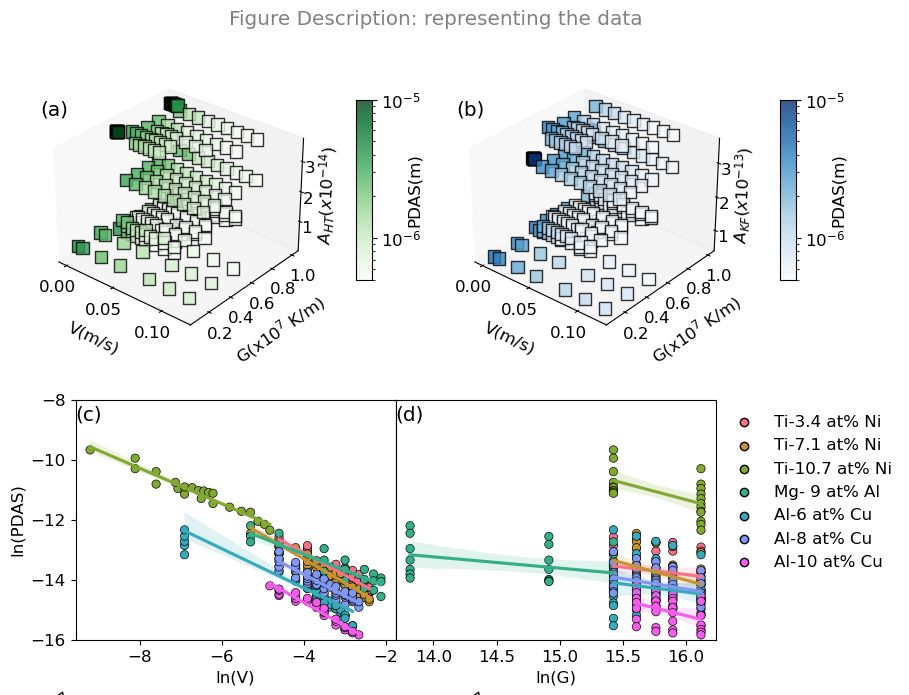

In [25]:
fig = plt.figure(facecolor="white",figsize=(8,6))
plt.rc('font', size=12)

ax = fig.add_axes([-0.05, 0.55, 0.45, 0.45],projection='3d')

ax.grid(False)
#fig.patch.set_facecolor('white')
ax.set_xlabel("V(m/s)")
ax.set_ylabel(r"G(x$10^{7}$ K/m)")
ax.set_zlabel(r"$A_{HT} (x10^{-14})$",labelpad=-10)
ax.set_xticks([0.0,0.05,0.1]) 

#ax.set_title("(a)",loc='left',pad=-20)
ax.set_title("(a)",y=0.8,loc="left")

ax.tick_params(axis='z', pad=-5)  # Adjust tick label position for z-axis
ax.tick_params(axis='y', pad=0)  # Adjust tick label position for z-axis
ax.tick_params(axis='x', pad=0) 

# Plot the data min(PDAS_list)
sc0 = ax.scatter(V_list, G_list, HT_list, c=PDAS_list, cmap='Greens',norm=LogNorm(vmin=5.0e-7,vmax=1e-5),marker= "s",s=80,edgecolor="black",alpha=0.8)
ax.view_init(elev=30.,azim=-50)  # elev is for elevation, azim is for azimuth

ax = fig.add_axes([0.4, 0.65, 0.02, 0.3])

cbar=plt.colorbar(sc0,label="PDAS(m)",cax=ax) #,fraction=0.1, pad=0.3
cbar.set_label("PDAS(m)", labelpad=-10) #
cbar.ax.xaxis.set_label_position('top')



ax = fig.add_axes([0.47, 0.55, 0.45, 0.45],projection='3d')
ax.grid(False)
#fig.patch.set_facecolor('white')
ax.set_xlabel("V(m/s)")
ax.set_ylabel(r"G(x$10^{7}$ K/m)")
ax.set_zlabel(r"$A_{KF} (x10^{-13}$)",labelpad=-10)
ax.set_xticks([0.0,0.05,0.1]) 

#ax.set_title("(b)",loc="left",pad=-20)
ax.set_title("(b)",y=0.8,loc="left")

ax.tick_params(axis='z', pad=-5)  # Adjust tick label position for z-axis
ax.tick_params(axis='y', pad=0)  # Adjust tick label position for z-axis
ax.tick_params(axis='x', pad=0)  # Adjust tick label position for z-axis

# Plot the data min(PDAS_list)
sc1 = ax.scatter(V_list, G_list, KF_list, c=PDAS_list, cmap='Blues',norm=LogNorm(vmin=5.0e-7,vmax=1e-5),marker= "s",s=80,edgecolor="black",alpha=0.8)
ax.view_init(elev=
             30, azim=-50)  # elev is for elevation, azim is for azimuth

ax = fig.add_axes([0.93, 0.65, 0.02, 0.3])

cbar=plt.colorbar(sc1,label="PDAS(m)",cax=ax) #,fraction=0.1, pad=0.3
cbar.set_label("PDAS(m)", labelpad=-10) #
cbar.ax.xaxis.set_label_position('top')

#fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=0.6, hspace=0.6)
#plt.tight_layout()



ax = fig.add_axes([0.05, 0.05, 0.4, 0.4])
ax.set_title("(c)",y=0.88,loc="left")

sns.scatterplot(data=df_ln,x="ln(V)",y="ln(PDAS)",hue="Alloy",palette=sns.color_palette("husl", 7),ax=ax,legend=False,edgecolor="black") #sizes=(20, 100),size="Mat_KF_ln",
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[0]],x="ln(V)",y="ln(PDAS)", scatter=False,line_kws={"color":color[0]},ax=ax) #,line_kws={"color":"red"}
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[1]],x="ln(V)",y="ln(PDAS)", scatter=False,line_kws={"color":color[1]},ax=ax)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[2]],x="ln(V)",y="ln(PDAS)", scatter=False,line_kws={"color":color[2]},ax=ax)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[3]],x="ln(V)",y="ln(PDAS)", scatter=False,line_kws={"color":color[3]},ax=ax)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[4]],x="ln(V)",y="ln(PDAS)", scatter=False,line_kws={"color":color[4]},ax=ax)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[5]],x="ln(V)",y="ln(PDAS)", scatter=False,line_kws={"color":color[5]},ax=ax)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[6]],x="ln(V)",y="ln(PDAS)", scatter=False,line_kws={"color":color[6]},ax=ax)
ax.set_xlabel("ln(V)")
ax.set_ylabel("ln(PDAS)")
ax.set_ylim([-16,-8])

ax1 = fig.add_axes([0.45, 0.05, 0.4, 0.4])
ax1.set_title("(d)",y=0.88,loc="left")

sns.scatterplot(data=df_ln,x="ln(G)",y="ln(PDAS)",hue="Alloy",palette=sns.color_palette("husl", 7),ax=ax1,edgecolor="black") #sizes=(20, 100),size="Mat_KF_ln",
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[0]],x="ln(G)",y="ln(PDAS)", scatter=False,line_kws={"color":color[0]},ax=ax1) #,line_kws={"color":"red"}
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[1]],x="ln(G)",y="ln(PDAS)", scatter=False,line_kws={"color":color[1]},ax=ax1)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[2]],x="ln(G)",y="ln(PDAS)", scatter=False,line_kws={"color":color[2]},ax=ax1)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[3]],x="ln(G)",y="ln(PDAS)", scatter=False,line_kws={"color":color[3]},ax=ax1)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[4]],x="ln(G)",y="ln(PDAS)", scatter=False,line_kws={"color":color[4]},ax=ax1)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[5]],x="ln(G)",y="ln(PDAS)", scatter=False,line_kws={"color":color[5]},ax=ax1)
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[6]],x="ln(G)",y="ln(PDAS)", scatter=False,line_kws={"color":color[6]},ax=ax1)
ax1.set_xlabel("ln(G)")
ax1.set_ylim([-16,-8])

plt.yticks([])  
ax1.set_ylabel("")


#axes[1].set_ylabel("ln(PDAS)")

#ax0 = fig.add_axes([0.95, 0.05, 0.4, 0.4])
handles, labels = ax1.get_legend_handles_labels()

# Iterate through the handles and call `set_edgecolor` on each
for ha in handles:
    ha.set_edgecolor("black")
ax1.legend(bbox_to_anchor=(1.6, 1.00), loc="upper right",frameon=False,prop={'size': 12})
#plt.tight_layout()
           
            
            
            
fig.suptitle('Figure Description: representing the data',c="grey",y=1.1) # or plt.suptitle('Main title')
            
            
plt.show()
fig.savefig('../Figure_new/PDAS.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')


This shows we obtain a decending behavior between PDAS with both V and G , while it seems V have a stronger effect. This was also supported by the heatmap plot.

# Modeling 

In [27]:
# This will hold A, alpha, beta, gamma and their std (PDAS=A (V)^alpha (G)^beta (matprop)^gamma) and their standard deviations
#the order of columns is HB, KF, "Ti-3.4 at% Ni","Ti-7.1 at% Ni","Ti-10.7 at% Ni","Mg- 9 at% Al","Al-6 at% Cu","Al-8 at% Cu","Al-10 at% Cu"
all_coefficients=np.zeros((9,8))
all_outputs=["All (HB model)", "All (KF model)"]+outputs

In [28]:
# Create test and train datasets
# Include all columns from df_ln in the explanatory variables X except "PDAS_ln","Mat_KF_ln"
x_ht=df_ln.drop(["ln(PDAS)",r"ln($A_{KF}$)","Alloy"],axis=1)

# Create constants for X, so the model knows its bounds
x_ht=sm.add_constant(x_ht)
y_ht=df[["ln(PDAS)"]]

# Split the data
x_train_ht,x_test_ht,y_train_ht,y_test_ht=train_test_split(x_ht,y_ht,test_size=0.25,random_state=42)

In [29]:
# Create test and train datasets
# Include all columns from df_ln in the explanatory variables X except "PDAS_ln","Mat_KF_ln"
x_kf=df_ln.drop(["ln(PDAS)",r"ln($A_{HT}$)","Alloy"],axis=1)

# Create constants for X, so the model knows its bounds
x_kf=sm.add_constant(x_kf)
y_kf=df[["ln(PDAS)"]]

# Split the data
x_train_kf,x_test_kf,y_train_kf,y_test_kf=train_test_split(x_kf,y_kf,test_size=0.25,random_state=45342)

# 1. Parametric models

## 1.1 Linear Regression

###  1.1.1 HT


In [30]:
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
rModel_ht_cv = linear_model.LinearRegression()
cv_result_ht = cross_validate(rModel_ht_cv, x_ht, y_ht, cv=kf, return_estimator=True)

pred_test_ht_LR = np.zeros((num_split, x_test_ht.shape[0]))
pred_train_ht_LR = np.zeros((num_split, x_train_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_test_ht_LR[i, :] = estimator.predict(x_test_ht).flatten()
    pred_train_ht_LR[i, :] = estimator.predict(x_train_ht).flatten()

# Average predictions across all folds
predictions_test_ht_LR = np.mean(pred_test_ht_LR, axis=0)
predictions_train_ht_LR = np.mean(pred_train_ht_LR, axis=0)

scores_ht = cross_validate(rModel_ht_cv, x_ht, y_ht.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
MSE_ht_test_LR=round(np.mean(np.abs(scores_ht['test_neg_mean_squared_error'])),3)
MSE_ht_train_LR=round(np.mean(np.abs(scores_ht['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {MSE_ht_test_LR}")
r2_ht_test_LR=round(np.mean(np.abs(scores_ht['test_r2'])),3)
r2_ht_train_LR=round(np.mean(np.abs(scores_ht['train_r2'])),3)

# Extract coefficients from each fitted model
coefficients_ht = np.array([estimator.coef_ for estimator in cv_result_ht['estimator']])
intercepts_ht = np.array([estimator.intercept_ for estimator in cv_result_ht['estimator']])

# Calculate mean and standard deviation of coefficients and intercept
mean_coefficients = coefficients_ht.mean(axis=0)
std_coefficients = coefficients_ht.std(axis=0)
mean_intercept = intercepts_ht.mean()
std_intercept = intercepts_ht.std()

# Calculate 95% confidence intervals
ci_coefficients = np.quantile(coefficients_ht, [0.025, 0.975], axis=0)
ci_intercept = np.quantile(intercepts_ht, [0.025, 0.975])
low=ci_coefficients[0, :]
high=ci_coefficients[1, :]

print("The mean ln(V) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,1],3), round(std_coefficients[0,1],3), round(low[0, 1],3),round(high[0, 1],3) ))
print("The mean ln(G) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,2],3), round(std_coefficients[0,2],3), round(low[0, 2],3),round(high[0, 2],3) ))
print("The mean ln(matprop_ht) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,3],3), round(std_coefficients[0,3],3), round(low[0, 3],3),round(high[0, 3],3) ))
#print("The mean ln(matprop_ht) coeff for ht model  is {}, with stdev of {} and 95% CI of {}".format(np.mean(coeff[:, 3]), np.std(coeff[:, 3]), np.quantile(coeff[:, 3], [0.025, 0.975
# Print results
print("Mean Coefficients:")
#for i, col in enumerate(x_ht.columns):
#    print(f"{col}: Mean = {mean_coefficients[i]}, Std = {std_coefficients[i]}, 95% CI = {ci_coefficients[:, i]}")

#print(f"Intercept: Mean = {mean_intercept}, Std = {std_intercept}, 95% CI = {ci_intercept}")


# Print R² scores statistics
print("The mean R² score  for ht model for test is {}".format(r2_ht_test_LR))
print("The mean R² score  for ht model for test is {}".format(r2_ht_train_LR))
print("The mean MSE score  for ht model for test is {}".format(MSE_ht_test_LR))
print("The mean MSE score  for ht model for test is {}".format(MSE_ht_train_LR))

Smallest Mean Squared Error for test: 0.141
The mean ln(V) coeff for ht model is -0.699, with stdev of 0.006 and 95% CI of (-0.712,-0.691)
The mean ln(G) coeff for ht model is -0.676, with stdev of 0.011 and 95% CI of (-0.691,-0.656)
The mean ln(matprop_ht) coeff for ht model is 0.459, with stdev of 0.004 and 95% CI of (0.452,0.464)
Mean Coefficients:
The mean R² score  for ht model for test is 0.87
The mean R² score  for ht model for test is 0.89
The mean MSE score  for ht model for test is 0.141
The mean MSE score  for ht model for test is 0.137


### 1.1.2 KF


In [31]:
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
rModel_kf_cv = linear_model.LinearRegression()
cv_result_kf = cross_validate(rModel_kf_cv, x_kf, y_kf, cv=kf, return_estimator=True)

pred_test_kf_LR = np.zeros((num_split, x_test_kf.shape[0]))
pred_train_kf_LR = np.zeros((num_split, x_train_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_test_kf_LR[i, :] = estimator.predict(x_test_kf).flatten()
    pred_train_kf_LR[i, :] = estimator.predict(x_train_kf).flatten()

# Average predictions across all folds
predictions_test_kf_LR = np.mean(pred_test_kf_LR, axis=0)
predictions_train_kf_LR = np.mean(pred_train_kf_LR, axis=0)

scores_kf = cross_validate(rModel_kf_cv, x_kf, y_kf.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
MSE_kf_test_LR=round(np.mean(np.abs(scores_kf ['test_neg_mean_squared_error'])),3)
MSE_kf_train_LR=round(np.mean(np.abs(scores_kf ['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {MSE_kf_test_LR}")
r2_kf_test_LR=round(np.mean(np.abs(scores_kf ['test_r2'])),3)
r2_kf_train_LR=round(np.mean(np.abs(scores_kf ['train_r2'])),3)


# Extract coefficients from each fitted model
coefficients_kf = np.array([estimator.coef_ for estimator in cv_result_kf['estimator']])
intercepts_kf = np.array([estimator.intercept_ for estimator in cv_result_kf['estimator']])

# Calculate mean and standard deviation of coefficients and intercept
mean_coefficients = coefficients_kf.mean(axis=0)
std_coefficients = coefficients_kf.std(axis=0)
mean_intercept = intercepts_kf.mean()
std_intercept = intercepts_kf.std()

# Calculate 95% confidence intervals
ci_coefficients = np.quantile(coefficients_kf, [0.025, 0.975], axis=0)
ci_intercept = np.quantile(intercepts_kf, [0.025, 0.975])

low=ci_coefficients[0, :]
high=ci_coefficients[1, :]

print("The mean ln(V) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,1],3), round(std_coefficients[0,1],3), round(low[0, 1],3),round(high[0, 1],3) ))
print("The mean ln(G) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,2],3), round(std_coefficients[0,2],3), round(low[0, 2],3),round(high[0, 2],3) ))
print("The mean ln(matprop_kf) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,3],3), round(std_coefficients[0,3],3), round(low[0, 3],3),round(high[0, 3],3) ))
#print("The mean ln(matprop_kf) coeff for kf model  is {}, with stdev of {} and 95% CI of {}".format(np.mean(coeff[:, 3]), np.std(coeff[:, 3]), np.quantile(coeff[:, 3], [0.025, 0.975
# Print results
print("Mean Coefficients:")
#for i, col in enumerate(x_kf.columns):
#    print(f"{col}: Mean = {mean_coefficients[i]}, Std = {std_coefficients[i]}, 95% CI = {ci_coefficients[:, i]}")

#print(f"Intercept: Mean = {mean_intercept}, Std = {std_intercept}, 95% CI = {ci_intercept}")


# Print R² scores statistics
print("The mean R² score  for kf model for test is {}".format(r2_kf_test_LR))
print("The mean R² score  for kf model for test is {}".format(r2_kf_train_LR))
print("The mean MSE score  for kf model for test is {}".format(MSE_kf_test_LR))
print("The mean MSE score  for kf model for test is {}".format(MSE_kf_train_LR))

Smallest Mean Squared Error for test: 0.156
The mean ln(V) coeff for kf model is -0.719, with stdev of 0.007 and 95% CI of (-0.733,-0.71)
The mean ln(G) coeff for kf model is -0.836, with stdev of 0.012 and 95% CI of (-0.851,-0.82)
The mean ln(matprop_kf) coeff for kf model is 0.655, with stdev of 0.007 and 95% CI of (0.642,0.662)
Mean Coefficients:
The mean R² score  for kf model for test is 0.855
The mean R² score  for kf model for test is 0.879
The mean MSE score  for kf model for test is 0.156
The mean MSE score  for kf model for test is 0.151


In [32]:
#print(coefficients_ht)


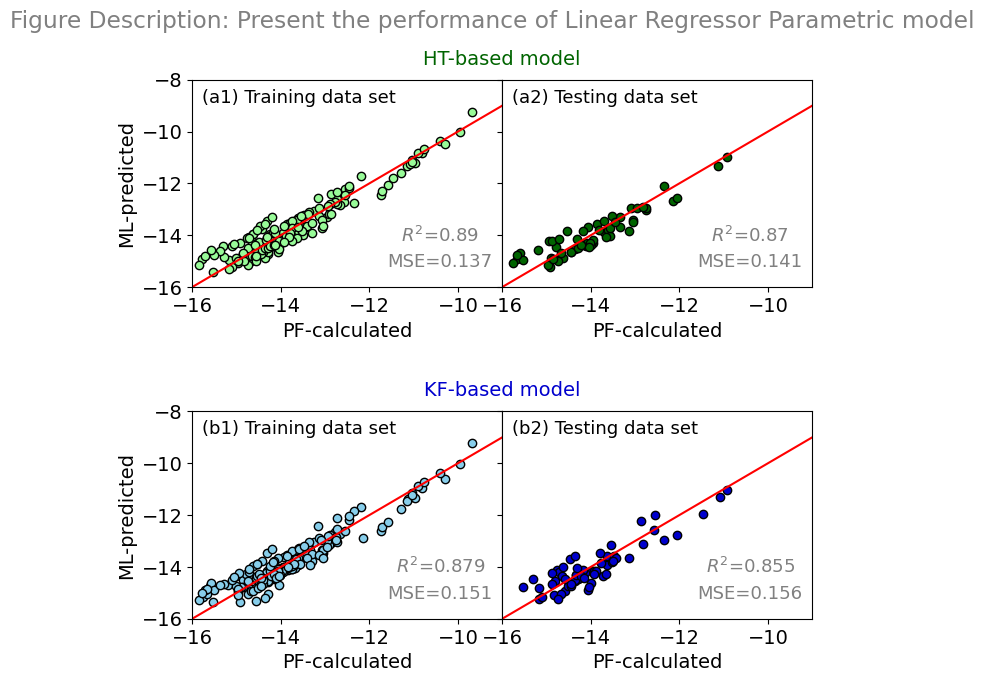

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7),sharey=True)
fig.subplots_adjust(wspace=0 , hspace=0.6)
fig.suptitle('Figure Description: Present the performance of Linear Regressor Parametric model',c="grey") # or plt.suptitle('Main title')

plt.rc('font', size=14)


axes[0,0].scatter(y_train_ht,predictions_train_ht_LR,edgecolor="black",c="palegreen")
# Add a line for perfect correlation
axes[0,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,0].set_xlabel("Calculated ln(PDAS)")
axes[0,0].set_ylabel ("Predicted ln(PDAS)")
axes[0,0].set_ylim([-16,-8])
axes[0,0].set_xlim([-16,-9])
axes[0,0].set_title ("(a1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,0].text(1.0, 1.1, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")
axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(r2_ht_train_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)
axes[0,0].text(0.8, 0.12, 'MSE='+str(MSE_ht_train_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)

axes[0,1].scatter(y_test_ht,predictions_test_ht_LR,edgecolor="black",c="darkgreen")
# Add a line for perfect correlation
axes[0,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,1].set_xlabel("Calculated ln(PDAS)")
axes[0,1].set_ylim([-16,-8])
axes[0,1].set_xlim([-16,-9])
axes[0,1].set_title ("(a2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(r2_ht_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)
axes[0,1].text(0.8, 0.12, 'MSE='+str(MSE_ht_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)


axes[1,0].scatter(y_train_kf,predictions_train_kf_LR,edgecolor="black",c="skyblue")
# Add a line for perfect correlation
axes[1,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylabel ("Predicted ln(PDAS)")
axes[1,0].set_ylim([-16,-8])
axes[1,0].set_xlim([-16,-9])
axes[1,0].set_title ("(b1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,0].text(1.0, 1.1, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="mediumblue")
axes[1,0].text(0.8, 0.25, r'$R^{2}$='+str(r2_kf_train_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)
axes[1,0].text(0.8, 0.12, 'MSE='+str(MSE_kf_train_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)

axes[1,1].scatter(y_test_kf,predictions_test_kf_LR,edgecolor="black",c="mediumblue")
# Add a line for perfect correlation
axes[1,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,1].set_xlabel("Calculated ln(PDAS)")
axes[1,1].set_ylim([-16,-8])
axes[1,1].set_xlim([-16,-9])
axes[1,1].set_title ("(b2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(r2_kf_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)
axes[1,1].text(0.8, 0.12, 'MSE='+str(MSE_kf_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)
fig.savefig('../Figure_new/predict_calculate_LR.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Text(0.5, 0.47, '$\\gamma_{mean}$=0.65')

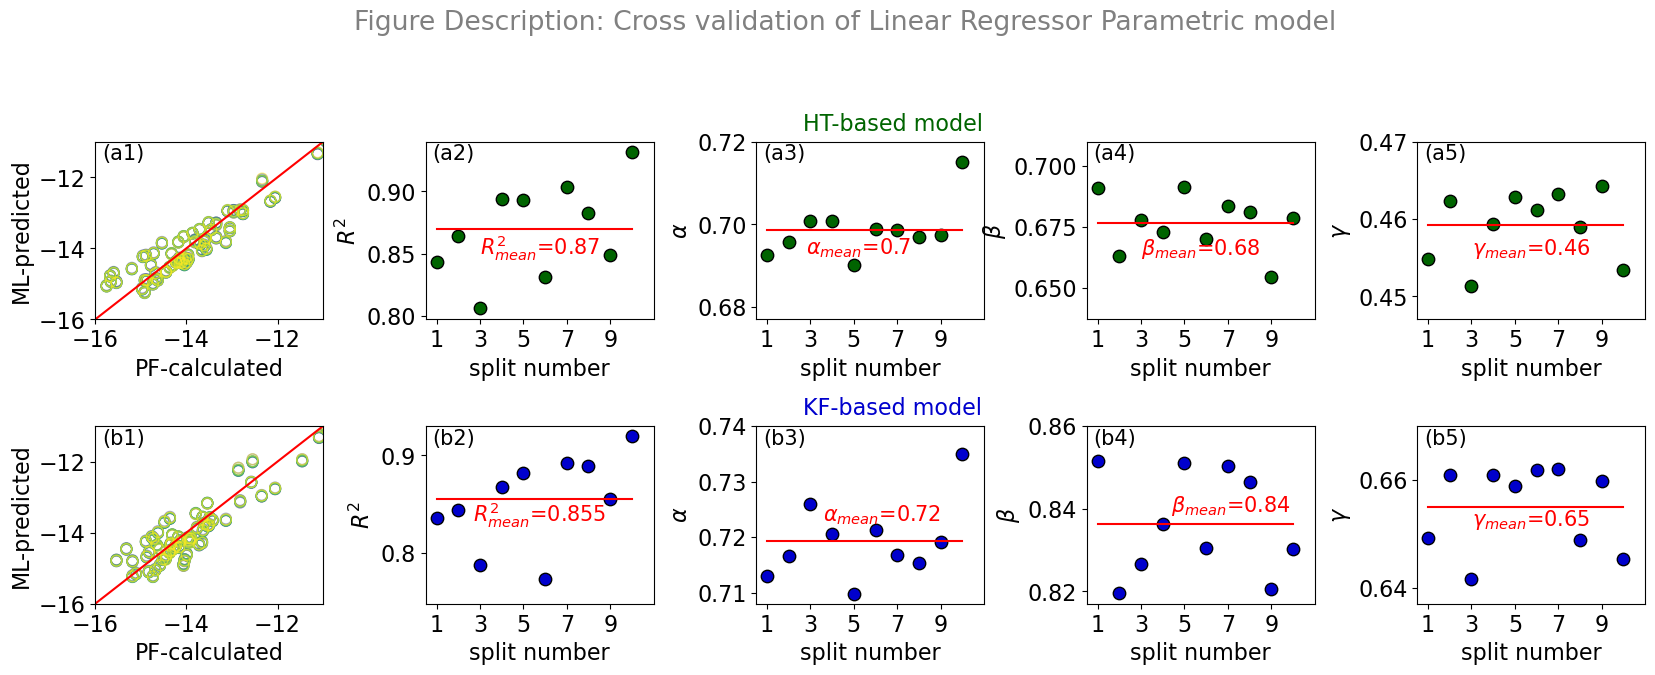

In [35]:
colors = cm.viridis(np.linspace(0, 1, num_split))
ll=[i+1 for i in range(10)]
print(ll)

fig, axes = plt.subplots(2, 5, figsize=(20, 6))
fig.suptitle('Figure Description: Cross validation of Linear Regressor Parametric model',c="grey",y=1.1) # or plt.suptitle('Main title')

fig.subplots_adjust(wspace=0.45 , hspace=0.6)

plt.rc('font', size=16)

for y, c in zip(pred_test_ht_LR, colors):
    axes[0,0].scatter(y_test_ht, y, edgecolor=c,facecolor="none",alpha=0.5,s=60)

axes[0,0].plot([-16,-11],[-16,-11],marker="None",color="red")
axes[0,0].set_xlabel("Calculated ln(PDAS)")
axes[0,0].set_ylabel ("Predicted ln(PDAS)")
axes[0,0].set_ylim([-16,-11])
axes[0,0].set_xlim([-16,-11])
axes[0,0].set_title ("(a1)",size=15,y=0.85,loc="left",x=0.03)
axes[0,0].text(3.5, 1.1, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")
#axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(r2_ht_train_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=15)
#axes[0,0].text(0.8, 0.12, 'MSE='+str(MSE_ht_train_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=15)

axes[0,1].scatter(ll,np.abs(scores_ht['test_r2']),edgecolor="black",c="darkgreen",s=80)
# Add a line for perfect correlation
axes[0,1].set_xlabel("split number")
axes[0,1].set_ylabel(r'$R^{2}$')
axes[0,1].set_xticks([1, 3, 5,7, 9])
axes[0,1].set_xlim([0.5,11])
axes[0,1].set_title ("(a2)",size=15,y=0.85,loc="left",x=0.03)
axes[0,1].set_ylim([0.797,0.94])


#axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(r2_ht_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=15)
#axes[0,1].text(0.8, 0.12, 'MSE='+str(MSE_ht_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=15)


tmp_coeff=[]
for i in range(num_split):
    tmp=coefficients_ht[i][0]
    tmp_coeff.append(abs(tmp[1]))
#print(tmp_coeff)
    
axes[0,2].scatter(ll,tmp_coeff,edgecolor="black",c="darkgreen",s=80)
# Add a line for perfect correlation
axes[0,2].set_xlabel("split number")
axes[0,2].set_ylabel(r'$\alpha$')
axes[0,2].set_xticks([1, 3, 5,7, 9])
axes[0,2].set_xlim([0.5,11])
axes[0,2].set_title ("(a3)",size=15,y=0.85,loc="left",x=0.03)
axes[0,2].set_ylim([0.677,0.72])


tmp_coeff=[]
for i in range(num_split):
    tmp=coefficients_ht[i][0]
    tmp_coeff.append(abs(tmp[2]))
#print(tmp_coeff)
    
axes[0,3].scatter(ll,tmp_coeff,edgecolor="black",c="darkgreen",s=80)
# Add a line for perfect correlation
axes[0,3].set_xlabel("split number")
axes[0,3].set_ylabel(r'$\beta$')
axes[0,3].set_xticks([1, 3, 5,7, 9])
axes[0,3].set_xlim([0.5,11])
axes[0,3].set_title ("(a4)",size=15,y=0.85,loc="left",x=0.03)
axes[0,3].set_ylim([0.637,0.71])



tmp_coeff=[]
for i in range(num_split):
    tmp=coefficients_ht[i][0]
    tmp_coeff.append(abs(tmp[3]))
#print(tmp_coeff)
    
axes[0,4].scatter(ll,tmp_coeff,edgecolor="black",c="darkgreen",s=80)
# Add a line for perfect correlation
axes[0,4].set_xlabel("split number")
axes[0,4].set_ylabel(r'$\gamma$')
axes[0,4].set_xticks([1, 3, 5,7, 9])
axes[0,4].set_xlim([0.5,11])
axes[0,4].set_title ("(a5)",size=15,y=0.85,loc="left",x=0.03)

axes[0,4].set_ylim([0.447,0.47])


for y, c in zip(pred_test_kf_LR, colors):
    axes[1,0].scatter(y_test_kf, y, edgecolor=c,facecolor="none",alpha=0.5,s=60)

axes[1,0].plot([-16,-11],[-16,-11],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylabel ("Predicted ln(PDAS)")
axes[1,0].set_ylim([-16,-11])
axes[1,0].set_xlim([-16,-11])
axes[1,0].set_title ("(b1)",size=15,y=0.85,loc="left",x=0.03)
axes[1,0].text(3.5, 1.1, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="mediumblue")
#axes[1,0].text(0.8, 0.5, r'$R^{2}_{mean}$='+str(r2_kf_train_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=15)
#axes[1,0].text(0.8, 0.12, 'MSE='+str(MSE_kf_train_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=15)

axes[1,1].scatter(ll,np.abs(scores_kf['test_r2']),edgecolor="black",c="mediumblue",s=80)
# Add a line for perfect correlation
axes[1,1].set_xlabel("split number")
axes[1,1].set_ylabel(r'$R^{2}$')
axes[1,1].set_xticks([1, 3, 5,7, 9])
axes[1,1].set_xlim([0.5,11])
axes[1,1].set_title ("(b2)",size=15,y=0.85,loc="left",x=0.03)
axes[1,1].set_ylim([0.748,0.93])

#axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(r2_kf_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=15)
#axes[1,1].text(0.8, 0.12, 'MSE='+str(MSE_kf_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=15)


tmp_coeff=[]
for i in range(num_split):
    tmp=coefficients_kf[i][0]
    tmp_coeff.append(abs(tmp[1]))
#print(tmp_coeff)
    
axes[1,2].scatter(ll,tmp_coeff,edgecolor="black",c="mediumblue",s=80)
# Add a line for perfect correlation
axes[1,2].set_xlabel("split number")
axes[1,2].set_ylabel(r'$\alpha$')
axes[1,2].set_xticks([1, 3, 5,7, 9])
axes[1,2].set_xlim([0.5,11])
axes[1,2].set_title ("(b3)",size=15,y=0.85,loc="left",x=0.03)
axes[1,2].set_ylim([0.708,0.74])


tmp_coeff=[]
for i in range(num_split):
    tmp=coefficients_kf[i][0]
    tmp_coeff.append(abs(tmp[2]))
#print(tmp_coeff)
    
axes[1,3].scatter(ll,tmp_coeff,edgecolor="black",c="mediumblue",s=80)
# Add a line for perfect correlation
axes[1,3].set_xlabel("split number")
axes[1,3].set_ylabel(r'$\beta$')
axes[1,3].set_xticks([1, 3, 5,7, 9])
axes[1,3].set_xlim([0.5,11])
axes[1,3].set_title ("(b4)",size=15,y=0.85,loc="left",x=0.03)
axes[1,3].set_ylim([0.817,0.86])



tmp_coeff=[]
for i in range(num_split):
    tmp=coefficients_kf[i][0]
    tmp_coeff.append(abs(tmp[3]))
#print(tmp_coeff)
    
axes[1,4].scatter(ll,tmp_coeff,edgecolor="black",c="mediumblue",s=80)
# Add a line for perfect correlation
axes[1,4].set_xlabel("split number")
axes[1,4].set_ylabel(r'$\gamma$')
axes[1,4].set_xticks([1, 3, 5,7, 9])
axes[1,4].set_xlim([0.5,11])
axes[1,4].set_title ("(b5)",size=15,y=0.85,loc="left",x=0.03)
axes[1,4].set_ylim([0.637,0.67])

axes[0,1].text(0.5, 0.4, r'$R^{2}_{mean}$='+str(r2_ht_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="red",size=15)
axes[0,1].plot([1,10],[r2_ht_test_LR,r2_ht_test_LR],marker="None",color="red")
axes[0,2].plot([1,10],[abs(coefficients_ht.mean(axis=0)[0,1]),abs(coefficients_ht.mean(axis=0)[0,1])],marker="None",color="red")
axes[0,2].text(0.45, 0.4, r'$\alpha_{mean}$='+str(round(abs(coefficients_ht.mean(axis=0)[0,1]),2)), horizontalalignment='center', verticalalignment='center', transform=axes[0,2].transAxes,c="red",size=15)

axes[0,3].plot([1,10],[abs(coefficients_ht.mean(axis=0)[0,2]),abs(coefficients_ht.mean(axis=0)[0,2])],marker="None",color="red")
axes[0,3].text(0.5, 0.4, r'$\beta_{mean}$='+str(round(abs(coefficients_ht.mean(axis=0)[0,2]),2)), horizontalalignment='center', verticalalignment='center', transform=axes[0,3].transAxes,c="red",size=15)

axes[0,4].plot([1,10],[abs(coefficients_ht.mean(axis=0)[0,3]),abs(coefficients_ht.mean(axis=0)[0,3])],marker="None",color="red")
axes[0,4].text(0.5, 0.4, r'$\gamma_{mean}$='+str(round(abs(coefficients_ht.mean(axis=0)[0,3]),2)), horizontalalignment='center', verticalalignment='center', transform=axes[0,4].transAxes,c="red",size=15)



axes[1,1].text(0.5, 0.5, r'$R^{2}_{mean}$='+str(r2_kf_test_LR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="red",size=15)
axes[1,1].plot([1,10],[r2_kf_test_LR,r2_kf_test_LR],marker="None",color="red")
axes[1,2].plot([1,10],[abs(coefficients_kf.mean(axis=0)[0,1]),abs(coefficients_kf.mean(axis=0)[0,1])],marker="None",color="red")
axes[1,2].text(0.55, 0.5, r'$\alpha_{mean}$='+str(round(abs(coefficients_kf.mean(axis=0)[0,1]),2)), horizontalalignment='center', verticalalignment='center', transform=axes[1,2].transAxes,c="red",size=15)

axes[1,3].plot([1,10],[abs(coefficients_kf.mean(axis=0)[0,2]),abs(coefficients_kf.mean(axis=0)[0,2])],marker="None",color="red")
axes[1,3].text(0.63, 0.55, r'$\beta_{mean}$='+str(round(abs(coefficients_kf.mean(axis=0)[0,2]),2)), horizontalalignment='center', verticalalignment='center', transform=axes[1,3].transAxes,c="red",size=15)

axes[1,4].plot([1,10],[abs(coefficients_kf.mean(axis=0)[0,3]),abs(coefficients_kf.mean(axis=0)[0,3])],marker="None",color="red")
axes[1,4].text(0.5, 0.47, r'$\gamma_{mean}$='+str(round(abs(coefficients_kf.mean(axis=0)[0,3]),2)), horizontalalignment='center', verticalalignment='center', transform=axes[1,4].transAxes,c="red",size=15)



## 1.2 Ridge Rigression Modle

### 1.2.1 HT model

In [37]:
alpha=np.arange(0.01,3,0.01)
#min_samples_leaf = range(1, 10, 2)


random_grid = {'alpha': alpha}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_4_gs_ht = linear_model.Ridge()

# Perform grid search
gs_ht = GridSearchCV(model_4_gs_ht, random_grid, cv=kf)
gs_ht.fit(x_train_ht, y_train_ht.values.ravel())

# Perform cross-validation and collect results
cv_result_ht = cross_validate(gs_ht, x_ht, y_ht, cv=kf, return_estimator=True)
scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring='neg_mean_squared_error')

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_ht['estimator'][best_index]
best_params = best_estimator.best_params_
MSF_ht_RR=abs(scores.mean())
print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {MSF_ht_RR}")
alpha_ht_op=best_params['alpha']

scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring='r2')
r2_ht_RR=abs(scores.mean())

print(f"R2: {r2_ht_RR}")


Best Grid Search Setup: {'alpha': 1.86}
Smallest Mean Squared Error: 0.14103191551529273
R2: 0.8699085535892157


In [38]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_4_ht = linear_model.Ridge(alpha=alpha_ht_op,fit_intercept=True)
cv_result_ht=cross_validate(model_4_ht,x_ht,y_ht,cv=kf,return_estimator=True)

pred_test_ht_RR = np.zeros((num_split, x_test_ht.shape[0]))
pred_train_ht_RR = np.zeros((num_split, x_train_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_test_ht_RR[i, :] = estimator.predict(x_test_ht).flatten()
    pred_train_ht_RR[i, :] = estimator.predict(x_train_ht).flatten()

# Average predictions across all folds
predictions_test_ht_RR = np.mean(pred_test_ht_RR, axis=0)
predictions_train_ht_RR = np.mean(pred_train_ht_RR, axis=0)

scores= cross_validate(model_4_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
MSE_ht_test_RR=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
MSE_ht_train_RR=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {MSE_ht_test_RR}")
r2_ht_test_RR=round(np.mean(np.abs(scores['test_r2'])),3)
r2_ht_train_RR=round(np.mean(np.abs(scores['train_r2'])),3)


# Extract coefficients from each fitted model
coefficients = np.array([estimator.coef_ for estimator in cv_result_ht['estimator']])
intercepts = np.array([estimator.intercept_ for estimator in cv_result_ht['estimator']])

# Calculate mean and standard deviation of coefficients and intercept
mean_coefficients = coefficients.mean(axis=0)
std_coefficients = coefficients.std(axis=0)
mean_intercept = intercepts.mean()
std_intercept = intercepts.std()

# Calculate 95% confidence intervals
ci_coefficients = np.quantile(coefficients, [0.025, 0.975], axis=0)
ci_intercept = np.quantile(intercepts, [0.025, 0.975])

low=ci_coefficients[0, :]
high=ci_coefficients[1, :]

print("The mean ln(V) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,1],3), round(std_coefficients[0,1],3), round(low[0, 1],3),round(high[0, 1],3) ))
print("The mean ln(G) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,2],3), round(std_coefficients[0,2],3), round(low[0, 2],3),round(high[0, 2],3) ))
print("The mean ln(matprop_ht) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,3],3), round(std_coefficients[0,3],3), round(low[0, 3],3),round(high[0, 3],3) ))
#print("The mean ln(matprop_ht) coeff for ht model  is {}, with stdev of {} and 95% CI of {}".format(np.mean(coeff[:, 3]), np.std(coeff[:, 3]), np.quantile(coeff[:, 3], [0.025, 0.975
# Print results
print("Mean Coefficients:")
#for i, col in enumerate(x_ht.columns):
#    print(f"{col}: Mean = {mean_coefficients[i]}, Std = {std_coefficients[i]}, 95% CI = {ci_coefficients[:, i]}")

#print(f"Intercept: Mean = {mean_intercept}, Std = {std_intercept}, 95% CI = {ci_intercept}")


# Print R² scores statistics
print("The mean R² score  for ht model for test is {}".format(r2_ht_test_RR))
print("The mean R² score  for ht model for test is {}".format(r2_ht_train_RR))
print("The mean MSE score  for ht model for test is {}".format(MSE_ht_test_RR))
print("The mean MSE score  for ht model for test is {}".format(MSE_ht_train_RR))

Smallest Mean Squared Error for test: 0.141
The mean ln(V) coeff for ht model is -0.695, with stdev of 0.006 and 95% CI of (-0.707,-0.687)
The mean ln(G) coeff for ht model is -0.645, with stdev of 0.01 and 95% CI of (-0.658,-0.627)
The mean ln(matprop_ht) coeff for ht model is 0.455, with stdev of 0.004 and 95% CI of (0.448,0.46)
Mean Coefficients:
The mean R² score  for ht model for test is 0.87
The mean R² score  for ht model for test is 0.89
The mean MSE score  for ht model for test is 0.141
The mean MSE score  for ht model for test is 0.137


### 1.2.2 KF model

In [39]:
alpha=np.arange(0.01,3,0.01)
#min_samples_leaf = range(1, 10, 2)


random_grid = {'alpha': alpha}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_4_gs_kf = linear_model.Ridge()

# Perform grid search
gs_kf = GridSearchCV(model_4_gs_kf, random_grid, cv=kf)
gs_kf.fit(x_train_kf, y_train_kf.values.ravel())

# Perform cross-validation and collect results
cv_result_kf = cross_validate(gs_kf, x_kf, y_kf, cv=kf, return_estimator=True)
scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='neg_mean_squared_error')

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_kf['estimator'][best_index]
best_params = best_estimator.best_params_
MSF_kf_RR=abs(scores.mean())
print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {MSF_kf_RR}")
alpha_kf_op=best_params['alpha']

scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='r2')
r2_kf_RR=abs(scores.mean())

print(f"R2: {r2_kf_RR}")


Best Grid Search Setup: {'alpha': 1.83}
Smallest Mean Squared Error: 0.1559781242143777
R2: 0.854641462918026


In [40]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_4_kf = linear_model.Ridge(alpha=alpha_kf_op,fit_intercept=True)
cv_result_kf=cross_validate(model_4_kf,x_kf,y_kf,cv=kf,return_estimator=True)

pred_test_kf_RR = np.zeros((num_split, x_test_kf.shape[0]))
pred_train_kf_RR = np.zeros((num_split, x_train_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_test_kf_RR[i, :] = estimator.predict(x_test_kf).flatten()
    pred_train_kf_RR[i, :] = estimator.predict(x_train_kf).flatten()

# Average predictions across all folds
predictions_test_kf_RR = np.mean(pred_test_kf_RR, axis=0)
predictions_train_kf_RR = np.mean(pred_train_kf_RR, axis=0)

scores= cross_validate(model_4_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
MSE_kf_test_RR=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
MSE_kf_train_RR=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {MSE_kf_test_RR}")
r2_kf_test_RR=round(np.mean(np.abs(scores['test_r2'])),3)
r2_kf_train_RR=round(np.mean(np.abs(scores['train_r2'])),3)


# Extract coefficients from each fitted model
coefficients = np.array([estimator.coef_ for estimator in cv_result_kf['estimator']])
intercepts = np.array([estimator.intercept_ for estimator in cv_result_kf['estimator']])

# Calculate mean and standard deviation of coefficients and intercept
mean_coefficients = coefficients.mean(axis=0)
std_coefficients = coefficients.std(axis=0)
mean_intercept = intercepts.mean()
std_intercept = intercepts.std()

# Calculate 95% confidence intervals
ci_coefficients = np.quantile(coefficients, [0.025, 0.975], axis=0)
ci_intercept = np.quantile(intercepts, [0.025, 0.975])

low=ci_coefficients[0, :]
high=ci_coefficients[1, :]

print("The mean ln(V) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,1],3), round(std_coefficients[0,1],3), round(low[0, 1],3),round(high[0, 1],3) ))
print("The mean ln(G) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,2],3), round(std_coefficients[0,2],3), round(low[0, 2],3),round(high[0, 2],3) ))
print("The mean ln(matprop_kf) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[0,3],3), round(std_coefficients[0,3],3), round(low[0, 3],3),round(high[0, 3],3) ))
#print("The mean ln(matprop_kf) coeff for kf model  is {}, with stdev of {} and 95% CI of {}".format(np.mean(coeff[:, 3]), np.std(coeff[:, 3]), np.quantile(coeff[:, 3], [0.025, 0.975
# Print results
print("Mean Coefficients:")
#for i, col in enumerate(x_kf.columns):
#    print(f"{col}: Mean = {mean_coefficients[i]}, Std = {std_coefficients[i]}, 95% CI = {ci_coefficients[:, i]}")

#print(f"Intercept: Mean = {mean_intercept}, Std = {std_intercept}, 95% CI = {ci_intercept}")


# Print R² scores statistics
print("The mean R² score  for kf model for test is {}".format(r2_kf_test_RR))
print("The mean R² score  for kf model for test is {}".format(r2_kf_train_RR))
print("The mean MSE score  for kf model for test is {}".format(MSE_kf_test_RR))
print("The mean MSE score  for kf model for test is {}".format(MSE_kf_train_RR))

Smallest Mean Squared Error for test: 0.156
The mean ln(V) coeff for kf model is -0.716, with stdev of 0.006 and 95% CI of (-0.728,-0.707)
The mean ln(G) coeff for kf model is -0.793, with stdev of 0.011 and 95% CI of (-0.808,-0.777)
The mean ln(matprop_kf) coeff for kf model is 0.639, with stdev of 0.007 and 95% CI of (0.627,0.646)
Mean Coefficients:
The mean R² score  for kf model for test is 0.855
The mean R² score  for kf model for test is 0.879
The mean MSE score  for kf model for test is 0.156
The mean MSE score  for kf model for test is 0.152


In [43]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7),sharey=True)
fig.subplots_adjust(wspace=0 , hspace=0.6)

plt.rc('font', size=14)


axes[0,0].scatter(y_train_ht,predictions_train_ht_RR,edgecolor="black",c="palegreen")
# Add a line for perfect correlation
axes[0,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,0].set_xlabel("Calculated ln(PDAS)")
axes[0,0].set_ylabel ("Predicted ln(PDAS)")
axes[0,0].set_ylim([-16,-8])
axes[0,0].set_xlim([-16,-9])
axes[0,0].set_title ("(a1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,0].text(1.0, 1.1, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")
axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(r2_ht_train_RR), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)
axes[0,0].text(0.8, 0.12, 'MSE='+str(MSE_ht_train_RR), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)

axes[0,1].scatter(y_test_ht,predictions_test_ht_RR,edgecolor="black",c="darkgreen")
# Add a line for perfect correlation
axes[0,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,1].set_xlabel("Calculated ln(PDAS)")
axes[0,1].set_ylim([-16,-8])
axes[0,1].set_xlim([-16,-9])
axes[0,1].set_title ("(a2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(r2_ht_test_RR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)
axes[0,1].text(0.8, 0.12, 'MSE='+str(MSE_ht_test_RR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)


axes[1,0].scatter(y_train_kf,predictions_train_kf_RR,edgecolor="black",c="skyblue")
# Add a line for perfect correlation
axes[1,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylabel("Predicted ln(PDAS)")
axes[1,0].set_ylim([-16,-8])
axes[1,0].set_xlim([-16,-9])
axes[1,0].set_title ("(b1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,0].text(1.0, 1.1, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="mediumblue")
axes[1,0].text(0.8, 0.25, r'$R^{2}$='+str(r2_kf_train_RR), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)
axes[1,0].text(0.8, 0.12, 'MSE='+str(MSE_kf_train_RR), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)

axes[1,1].scatter(y_test_kf,predictions_test_kf_RR,edgecolor="black",c="mediumblue")
# Add a line for perfect correlation
axes[1,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,1].set_xlabel("Calculated ln(PDAS)")
axes[1,1].set_ylim([-16,-8])
axes[1,1].set_xlim([-16,-9])
axes[1,1].set_title ("(b2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(r2_kf_test_RR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)
axes[1,1].text(0.8, 0.12, 'MSE='+str(MSE_kf_test_RR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)
fig.savefig('../Figure_new/predict_calculate_RR.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')
plt.close(fig)

## 1.3 Lasso Model

### 1.3.1 HT model

In [44]:
alpha=np.arange(0.01,3,0.01)
#min_samples_leaf = range(1, 10, 2)


random_grid = {'alpha': alpha}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_5_gs_ht = linear_model.Lasso()

# Perform grid search
gs_ht = GridSearchCV(model_5_gs_ht, random_grid, cv=kf)
gs_ht.fit(x_train_ht, y_train_ht.values.ravel())

# Perform cross-validation and collect results
cv_result_ht = cross_validate(gs_ht, x_ht, y_ht, cv=kf, return_estimator=True)
scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring='neg_mean_squared_error')

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_ht['estimator'][best_index]
best_params = best_estimator.best_params_
MSF_ht_LaR=abs(scores.mean())
print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {MSF_ht_LaR}")
alpha_ht_op=best_params['alpha']

scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring='r2')
r2_ht_LaR=abs(scores.mean())

print(f"R2: {r2_ht_LaR}")


Best Grid Search Setup: {'alpha': 0.01}
Smallest Mean Squared Error: 0.14156556133855527
R2: 0.8692263194176755


In [45]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_5_ht = linear_model.Lasso(alpha=alpha_ht_op,fit_intercept=True)
cv_result_ht=cross_validate(model_5_ht,x_ht,y_ht,cv=kf,return_estimator=True)

pred_test_ht_LaR = np.zeros((num_split, x_test_ht.shape[0]))
pred_train_ht_LaR = np.zeros((num_split, x_train_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_test_ht_LaR[i, :] = estimator.predict(x_test_ht).flatten()
    pred_train_ht_LaR[i, :] = estimator.predict(x_train_ht).flatten()

# Average predictions across all folds
predictions_test_ht_LaR = np.mean(pred_test_ht_LaR, axis=0)
predictions_train_ht_LaR = np.mean(pred_train_ht_LaR, axis=0)

scores= cross_validate(model_5_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
MSE_ht_test_LaR=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
MSE_ht_train_LaR=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {MSE_ht_test_LaR}")
r2_ht_test_LaR=round(np.mean(np.abs(scores['test_r2'])),3)
r2_ht_train_LaR=round(np.mean(np.abs(scores['train_r2'])),3)


# Extract coefficients from each fitted model
coefficients = np.array([estimator.coef_ for estimator in cv_result_ht['estimator']])
intercepts = np.array([estimator.intercept_ for estimator in cv_result_ht['estimator']])

# Calculate mean and standard deviation of coefficients and intercept
mean_coefficients = coefficients.mean(axis=0)
std_coefficients = coefficients.std(axis=0)
mean_intercept = intercepts.mean()
std_intercept = intercepts.std()

# Calculate 95% confidence intervals
ci_coefficients = np.quantile(coefficients, [0.025, 0.975], axis=0)
ci_intercept = np.quantile(intercepts, [0.025, 0.975])
low=ci_coefficients[0, :]
high=ci_coefficients[1, :]

print(low)
print("The mean ln(V) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[1],3), round(std_coefficients[1],3), round(low[1],3),round(high[1],3) ))
print("The mean ln(G) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[2],3), round(std_coefficients[2],3), round(low[ 2],3),round(high[ 2],3) ))
print("The mean ln(matprop_ht) coeff for ht model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[3],3), round(std_coefficients[3],3), round(low[ 3],3),round(high[ 3],3) ))
#print("The mean ln(matprop_ht) coeff for ht model  is {}, with stdev of {} and 95% CI of {}".format(np.mean(coeff[:, 3]), np.std(coeff[:, 3]), np.quantile(coeff[:, 3], [0.025, 0.975
# Print results
print("Mean Coefficients:")
#for i, col in enumerate(x_ht.columns):
#    print(f"{col}: Mean = {mean_coefficients[i]}, Std = {std_coefficients[i]}, 95% CI = {ci_coefficients[:, i]}")

#print(f"Intercept: Mean = {mean_intercept}, Std = {std_intercept}, 95% CI = {ci_intercept}")


# Print R² scores statistics
print("The mean R² score  for ht model for test is {}".format(r2_ht_test_LaR))
print("The mean R² score  for ht model for test is {}".format(r2_ht_train_LaR))
print("The mean MSE score  for ht model for test is {}".format(MSE_ht_test_LaR))
print("The mean MSE score  for ht model for test is {}".format(MSE_ht_train_LaR))

Smallest Mean Squared Error for test: 0.141
[ 0.         -0.7039336  -0.63048046  0.44095946]
The mean ln(V) coeff for ht model is -0.692, with stdev of 0.006 and 95% CI of (-0.704,-0.685)
The mean ln(G) coeff for ht model is -0.617, with stdev of 0.01 and 95% CI of (-0.63,-0.6)
The mean ln(matprop_ht) coeff for ht model is 0.448, with stdev of 0.004 and 95% CI of (0.441,0.454)
Mean Coefficients:
The mean R² score  for ht model for test is 0.87
The mean R² score  for ht model for test is 0.89
The mean MSE score  for ht model for test is 0.141
The mean MSE score  for ht model for test is 0.137


### 1.3.2 KF model

In [46]:
alpha=np.arange(0.01,3,0.01)
#min_samples_leaf = range(1, 10, 2)


random_grid = {'alpha': alpha}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_5_gs_kf = linear_model.Lasso()

# Perform grid search
gs_kf = GridSearchCV(model_5_gs_kf, random_grid, cv=kf)
gs_kf.fit(x_train_kf, y_train_kf.values.ravel())

# Perform cross-validation and collect results
cv_result_kf = cross_validate(gs_kf, x_kf, y_kf, cv=kf, return_estimator=True)
scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='neg_mean_squared_error')

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_kf['estimator'][best_index]
best_params = best_estimator.best_params_
MSF_kf_LaR=abs(scores.mean())
print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {MSF_kf_LaR}")
alpha_kf_op=best_params['alpha']

scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='r2')
r2_kf_LaR=abs(scores.mean())

print(f"R2: {r2_kf_LaR}")


Best Grid Search Setup: {'alpha': 0.01}
Smallest Mean Squared Error: 0.1566753567104613
R2: 0.8539642153469437


In [47]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_5_kf = linear_model.Lasso(alpha=alpha_kf_op,fit_intercept=True)
cv_result_kf=cross_validate(model_5_kf,x_kf,y_kf,cv=kf,return_estimator=True)
scores= cross_val_score(model_5_kf, x_kf, y_kf, cv=kf, scoring='neg_mean_squared_error')
pred_test_kf_LaR = np.zeros((num_split, x_test_kf.shape[0]))
pred_train_kf_LaR = np.zeros((num_split, x_train_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_test_kf_LaR[i, :] = estimator.predict(x_test_kf).flatten()
    pred_train_kf_LaR[i, :] = estimator.predict(x_train_kf).flatten()

# Average predictions across all folds
predictions_test_kf_LaR = np.mean(pred_test_kf_LaR, axis=0)
predictions_train_kf_LaR = np.mean(pred_train_kf_LaR, axis=0)

scores= cross_validate(model_5_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
MSE_kf_test_LaR=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
MSE_kf_train_LaR=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {MSE_kf_test_LaR}")
r2_kf_test_LaR=round(np.mean(np.abs(scores['test_r2'])),3)
r2_kf_train_LaR=round(np.mean(np.abs(scores['train_r2'])),3)


# Extract coefficients from each fitted model
coefficients = np.array([estimator.coef_ for estimator in cv_result_kf['estimator']])
intercepts = np.array([estimator.intercept_ for estimator in cv_result_kf['estimator']])

# Calculate mean and standard deviation of coefficients and intercept
mean_coefficients = coefficients.mean(axis=0)
std_coefficients = coefficients.std(axis=0)
mean_intercept = intercepts.mean()
std_intercept = intercepts.std()

# Calculate 95% confidence intervals
ci_coefficients = np.quantile(coefficients, [0.025, 0.975], axis=0)
ci_intercept = np.quantile(intercepts, [0.025, 0.975])

low=ci_coefficients[0, :]
high=ci_coefficients[1, :]

print("The mean ln(V) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[1],3), round(std_coefficients[1],3), round(low[1],3),round(high[ 1],3) ))
print("The mean ln(G) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[2],3), round(std_coefficients[2],3), round(low[2],3),round(high[ 2],3) ))
print("The mean ln(matprop_kf) coeff for kf model is {}, with stdev of {} and 95% CI of ({},{})".format(round(mean_coefficients[3],3), round(std_coefficients[3],3), round(low[3],3),round(high[3],3) ))
#print("The mean ln(matprop_kf) coeff for kf model  is {}, with stdev of {} and 95% CI of {}".format(np.mean(coeff[:, 3]), np.std(coeff[:, 3]), np.quantile(coeff[:, 3], [0.025, 0.975
# Print results
print("Mean Coefficients:")
#for i, col in enumerate(x_kf.columns):
#    print(f"{col}: Mean = {mean_coefficients[i]}, Std = {std_coefficients[i]}, 95% CI = {ci_coefficients[:, i]}")

#print(f"Intercept: Mean = {mean_intercept}, Std = {std_intercept}, 95% CI = {ci_intercept}")


# Print R² scores statistics
print("The mean R² score  for kf model for test is {}".format(r2_kf_test_LaR))
print("The mean R² score  for kf model for test is {}".format(r2_kf_train_LaR))
print("The mean MSE score  for kf model for test is {}".format(MSE_kf_test_LaR))
print("The mean MSE score  for kf model for test is {}".format(MSE_kf_train_LaR))

Smallest Mean Squared Error for test: 0.156
The mean ln(V) coeff for kf model is -0.713, with stdev of 0.006 and 95% CI of (-0.725,-0.705)
The mean ln(G) coeff for kf model is -0.768, with stdev of 0.012 and 95% CI of (-0.784,-0.75)
The mean ln(matprop_kf) coeff for kf model is 0.626, with stdev of 0.007 and 95% CI of (0.614,0.633)
Mean Coefficients:
The mean R² score  for kf model for test is 0.855
The mean R² score  for kf model for test is 0.879
The mean MSE score  for kf model for test is 0.156
The mean MSE score  for kf model for test is 0.152


In [48]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7),sharey=True)
fig.subplots_adjust(wspace=0 , hspace=0.6)

plt.rc('font', size=14)


axes[0,0].scatter(y_train_ht,predictions_train_ht_LaR,edgecolor="black",c="palegreen")
# Add a line for perfect correlation
axes[0,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylabel("Predicted ln(PDAS)")
axes[0,0].set_ylim([-16,-8])
axes[0,0].set_xlim([-16,-9])
axes[0,0].set_title ("(a1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,0].text(1.0, 1.1, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")
axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(r2_ht_train_LaR), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)
axes[0,0].text(0.8, 0.12, 'MSE='+str(MSE_ht_train_LaR), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)

axes[0,1].scatter(y_test_ht,predictions_test_ht_LaR,edgecolor="black",c="darkgreen")
# Add a line for perfect correlation
axes[0,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,1].set_xlabel("Calculated ln(PDAS)")
axes[0,1].set_ylim([-16,-8])
axes[0,1].set_xlim([-16,-9])
axes[0,1].set_title ("(a2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(r2_ht_test_LaR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)
axes[0,1].text(0.8, 0.12, 'MSE='+str(MSE_ht_test_LaR), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)


axes[1,0].scatter(y_train_kf,predictions_train_kf_LaR,edgecolor="black",c="skyblue")
# Add a line for perfect correlation
axes[1,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylabel("Predicted ln(PDAS)")
axes[1,0].set_ylim([-16,-8])
axes[1,0].set_xlim([-16,-9])
axes[1,0].set_title ("(b1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,0].text(1.0, 1.1, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="mediumblue")
axes[1,0].text(0.8, 0.25, r'$R^{2}$='+str(r2_kf_train_LaR), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)
axes[1,0].text(0.8, 0.12, 'MSE='+str(MSE_kf_train_LaR), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)

axes[1,1].scatter(y_test_kf,predictions_test_kf_LaR,edgecolor="black",c="mediumblue")
# Add a line for perfect correlation
axes[1,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,1].set_xlabel("Calculated ln(PDAS)")
axes[1,1].set_ylim([-16,-8])
axes[1,1].set_xlim([-16,-9])
axes[1,1].set_title ("(b2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(r2_kf_test_LaR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)
axes[1,1].text(0.8, 0.12, 'MSE='+str(MSE_kf_test_LaR), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)
fig.savefig('../Figure_new/predict_calculate_LaR.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')
plt.close(fig)

## 1.4 Figure of all

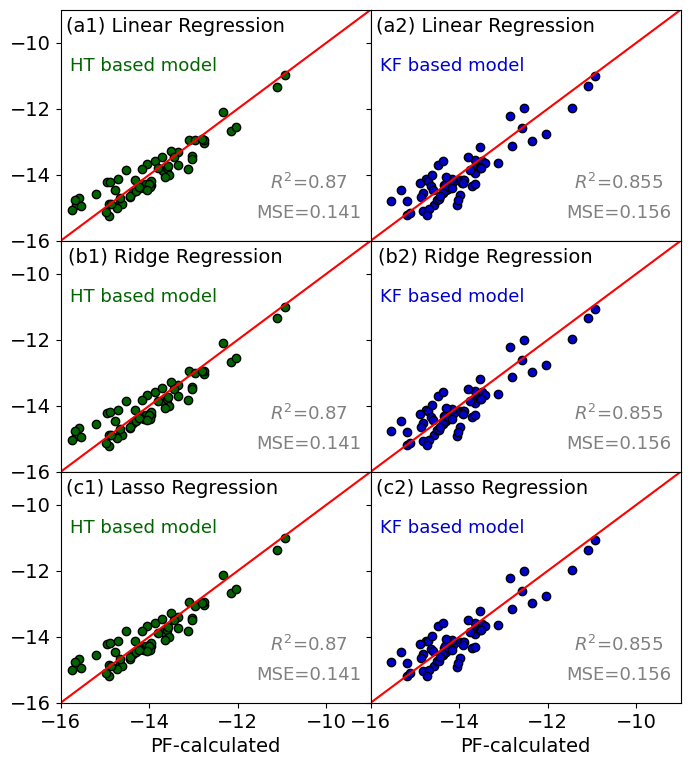

In [49]:
fig, axes = plt.subplots(3,2, figsize=(8, 9),sharey=True,sharex=True)
fig.subplots_adjust(wspace=0 , hspace=0)

plt.rc('font', size=14)


axes[0,0].scatter(y_test_ht,predictions_test_ht_LR,edgecolor="black",c="darkgreen")
# Add a line for perfect correlation
axes[0,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,0].set_xlabel("Calculated ln(PDAS)")
axes[0,0].set_ylim([-16,-9])
axes[0,0].set_xlim([-16,-9])
axes[0,0].text(0.37, 0.93, "(a1) Linear Regression", horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes)
axes[0,0].set_title ("HT based model",size=13,y=0.7,loc="left",x=0.03,c="darkgreen")
axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_ht_test_LR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)
axes[0,0].text(0.8, 0.12, 'MSE='+str(round(MSE_ht_test_LR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)


axes[0,1].scatter(y_test_kf,predictions_test_kf_LR,edgecolor="black",c="mediumblue")
# Add a line for perfect correlation
axes[0,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,1].set_xlabel("Calculated ln(PDAS)")
axes[0,1].set_ylim([-16,-9])
axes[0,1].set_xlim([-16,-9])
axes[0,1].text(0.37, 0.93, "(a2) Linear Regression", horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes)
axes[0,1].set_title ("KF based model",size=13,y=0.7,loc="left",x=0.03,c="mediumblue")
axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_kf_test_LR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)
axes[0,1].text(0.8, 0.12, 'MSE='+str(round(MSE_kf_test_LR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)


axes[1,0].scatter(y_test_ht,predictions_test_ht_RR,edgecolor="black",c="darkgreen")
# Add a line for perfect correlation
axes[1,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylim([-16,-9])
axes[1,0].set_xlim([-16,-9])
axes[1,0].text(0.37, 0.93, "(b1) Ridge Regression", horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes)
axes[1,0].set_title ("HT based model",size=13,y=0.7,loc="left",x=0.03,c="darkgreen")
axes[1,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_ht_test_RR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)
axes[1,0].text(0.8, 0.12, 'MSE='+str(round(MSE_ht_test_RR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)


axes[1,1].scatter(y_test_kf,predictions_test_kf_RR,edgecolor="black",c="mediumblue")
# Add a line for perfect correlation
axes[1,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,1].set_xlabel("Calculated ln(PDAS)")
axes[1,1].set_ylim([-16,-9])
axes[1,1].set_xlim([-16,-9])
axes[1,1].text(0.37, 0.93, "(b2) Ridge Regression", horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes)
axes[1,1].set_title ("KF based model",size=13,y=0.7,loc="left",x=0.03,c="mediumblue")
axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_kf_test_RR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)
axes[1,1].text(0.8, 0.12, 'MSE='+str(round(MSE_kf_test_RR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)

axes[2,0].scatter(y_test_ht,predictions_test_ht_LaR,edgecolor="black",c="darkgreen")
# Add a line for peXGBect correlation
axes[2,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[2,0].set_xlabel("Calculated ln(PDAS)")
axes[2,0].set_ylim([-16,-9])
axes[2,0].set_xlim([-16,-9])
axes[2,0].text(0.36, 0.93, "(c1) Lasso Regression", horizontalalignment='center', verticalalignment='center', transform=axes[2,0].transAxes)
axes[2,0].set_title ("HT based model",size=13,y=0.7,loc="left",x=0.03,c="darkgreen")
axes[2,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_ht_test_LaR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[2,0].transAxes,c="grey",size=13)
axes[2,0].text(0.8, 0.12, 'MSE='+str(round(MSE_ht_test_LaR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[2,0].transAxes,c="grey",size=13)


axes[2,1].scatter(y_test_kf,predictions_test_kf_LaR,edgecolor="black",c="mediumblue")
# Add a line for peXGBect correlation
axes[2,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[2,1].set_xlabel("Calculated ln(PDAS)")
axes[2,1].set_ylim([-16,-9])
axes[2,1].set_xlim([-16,-9])
axes[2,1].text(0.36, 0.93, "(c2) Lasso Regression", horizontalalignment='center', verticalalignment='center', transform=axes[2,1].transAxes)
axes[2,1].set_title ("KF based model",size=13,y=0.7,loc="left",x=0.03,c="mediumblue")
axes[2,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_kf_test_LaR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[2,1].transAxes,c="grey",size=13)
axes[2,1].text(0.8, 0.12, 'MSE='+str(round(MSE_kf_test_LaR,3)), horizontalalignment='center', verticalalignment='center', transform=axes[2,1].transAxes,c="grey",size=13)

fig.savefig('../Figure_new/parametrix_test.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')


# 2. Non-parametric models


## 2.1 General

In [52]:
def spotcheck(X_train,X_test,y_train, y_test):
  models =[("LinearR", linear_model.LinearRegression()),
          ("DTR", DecisionTreeRegressor()),  
          ('RF',RandomForestRegressor()),
          ('KNN', KNeighborsRegressor(n_neighbors=10)), 
          ("Ridge", linear_model.RidgeCV()),          
          ('ADA', AdaBoostRegressor()),
          ('XGB',GradientBoostingRegressor())]

  results = []
  names = []
  finalResults = []

  for name,model in models:
      model.fit(X_train, y_train.values.ravel())
      model_results = model.predict(X_test)
      r2score = r2_score(y_test, model_results) 
      MSE = mean_squared_error(y_test, model_results)
      MAE = mean_absolute_error(y_test, model_results)
      results.append(r2score)
      results.append(MSE)
      results.append(MAE)
      names.append(name)
      finalResults.append((name, r2score, MSE, MAE))
      
  finalResults.sort(key=lambda k:k[1],reverse=True)
  return finalResults

In [53]:
proofstress_df_ht = pd.DataFrame(spotcheck(x_train_ht,x_test_ht,y_train_ht, y_test_ht), columns=['Model Name', 'R2 Score', 'MSE', 'MAE'])
proofstress_df_ht

Model Name  R2 Score       MSE       MAE
0        XGB  0.977908  0.022120  0.110282
1         RF  0.973354  0.026680  0.115843
2        DTR  0.956694  0.043361  0.155165
3        ADA  0.879126  0.121028  0.295115
4        KNN  0.863765  0.136409  0.284606
5    LinearR  0.849741  0.150451  0.318394
6      Ridge  0.848499  0.151694  0.320624

In [54]:
proofstress_df_kf = pd.DataFrame(spotcheck(x_train_kf,x_test_kf,y_train_kf, y_test_kf), columns=['Model Name', 'R2 Score', 'MSE', 'MAE'])
proofstress_df_kf

Model Name  R2 Score       MSE       MAE
0         RF  0.977218  0.020532  0.111317
1        DTR  0.962502  0.033795  0.152921
2        XGB  0.961833  0.034397  0.139121
3        ADA  0.840968  0.143325  0.321693
4    LinearR  0.797705  0.182314  0.355923
5      Ridge  0.797632  0.182380  0.355921
6        KNN  0.768275  0.208838  0.367773

## 2.2 Decision tree

### 2.2.1 HT model

In [55]:
max_depth = range(1, 15, 1)
min_samples_split = range(2, 5, 1)
#min_samples_leaf = range(1, 10, 2)


random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_1_gs_ht = DecisionTreeRegressor()

# Perform grid search
gs_ht = GridSearchCV(model_1_gs_ht, random_grid, cv=kf)
gs_ht.fit(x_train_ht, y_train_ht.values.ravel())

# Perform cross-validation and collect results
cv_result_ht = cross_validate(gs_ht, x_ht, y_ht, cv=kf, return_estimator=True)
scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring='neg_mean_squared_error')

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_ht['estimator'][best_index]
best_params = best_estimator.best_params_
MSF_ht_DT=abs(scores.mean())
print(scores)
print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {MSF_ht_DT}")
max_depth_ht_op=best_params['max_depth']
min_samples_split_ht_op=best_params['min_samples_split']

scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring='r2')
r2_ht_DT=abs(scores.mean())
print(scores)

print(f"R2: {r2_ht_DT}")


[-0.01946016 -0.04537086 -0.03868709 -0.03587467 -0.02493123 -0.03613756
 -0.0183332  -0.04217478 -0.10185577 -0.0355469 ]
Best Grid Search Setup: {'max_depth': 11, 'min_samples_split': 2}
Smallest Mean Squared Error: 0.03983722181009451
[0.98152024 0.94420341 0.96730176 0.9686737  0.98200682 0.94681224
 0.97905077 0.96295155 0.90978946 0.98752528]
R2: 0.9629835205857376


In [82]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_1_ht = DecisionTreeRegressor(max_depth=max_depth_ht_op,min_samples_split=min_samples_split_ht_op)
cv_result_ht=cross_validate(model_1_ht,x_ht,y_ht,cv=kf,return_estimator=True)
scores= cross_val_score(model_1_ht, x_ht, y_ht, cv=kf, scoring='neg_mean_squared_error')
pred_test_ht_DT = np.zeros((num_split, x_test_ht.shape[0]))
pred_train_ht_DT = np.zeros((num_split, x_train_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_test_ht_DT[i, :] = estimator.predict(x_test_ht).flatten()
    pred_train_ht_DT[i, :] = estimator.predict(x_train_ht).flatten()

# Average predictions across all folds
predictions_ht_test_DT = np.mean(pred_test_ht_DT, axis=0)
predictions_ht_train_DT = np.mean(pred_train_ht_DT, axis=0)

scores= cross_validate(model_1_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
RMSE_train_ht_DT=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
RMSE_test_ht_DT=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {RMSE_test_ht_DT}")
r2_train_ht_DT=round(np.mean(np.abs(scores['test_r2'])),3)
r2_test_ht_DT=round(np.mean(np.abs(scores['train_r2'])),3)


Smallest Mean Squared Error for test: 0.006


## 2.2.2 KFmodel

In [57]:
max_depth = range(1, 15, 1)
min_samples_split = range(2, 5, 1)
#min_samples_leaf = range(1, 10, 2)


random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_1_gs_kf = DecisionTreeRegressor()

# Perform grid search
gs_kf = GridSearchCV(model_1_gs_kf, random_grid, cv=kf)
gs_kf.fit(x_train_kf, y_train_kf.values.ravel())

# Perform cross-validation and collect results
cv_result_kf = cross_validate(gs_kf, x_kf, y_kf, cv=kf, return_estimator=True)
scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='neg_mean_squared_error')

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_kf['estimator'][best_index]
best_params = best_estimator.best_params_
MSF_kf_DT=abs(scores.mean())
print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {MSF_kf_DT}")

print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {scores}")
max_depth_kf_op=best_params['max_depth']
min_samples_split_kf_op=best_params['min_samples_split']
scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='r2')
r2_kf_DT=abs(scores.mean())

print(f"R2: {r2_kf_DT}")

Best Grid Search Setup: {'max_depth': 14, 'min_samples_split': 2}
Smallest Mean Squared Error: 0.04176014972119663
Best Grid Search Setup: {'max_depth': 14, 'min_samples_split': 2}
Smallest Mean Squared Error: [-0.01910286 -0.03351723 -0.03763318 -0.08472045 -0.02366338 -0.02789012
 -0.01245103 -0.03858074 -0.1044956  -0.0355469 ]
R2: 0.9609914149433771


In [83]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_1_kf = DecisionTreeRegressor(max_depth=max_depth_kf_op,min_samples_split=min_samples_split_kf_op)
cv_result_kf=cross_validate(model_1_kf,x_kf,y_kf,cv=kf,return_estimator=True)
scores= cross_val_score(model_1_kf, x_kf, y_kf, cv=kf, scoring='neg_mean_squared_error')
pred_test_kf_DT = np.zeros((num_split, x_test_kf.shape[0]))
pred_train_kf_DT = np.zeros((num_split, x_train_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_test_kf_DT[i, :] = estimator.predict(x_test_kf).flatten()
    pred_train_kf_DT[i, :] = estimator.predict(x_train_kf).flatten()

# Average predictions across all folds
predictions_kf_test_DT = np.mean(pred_test_kf_DT, axis=0)
predictions_kf_train_DT = np.mean(pred_train_kf_DT, axis=0)

scores= cross_validate(model_1_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
RMSE_train_kf_DT=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
RMSE_test_kf_DT=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {RMSE_test_kf_DT}")
r2_train_kf_DT=round(np.mean(np.abs(scores['test_r2'])),3)
r2_test_kf_DT=round(np.mean(np.abs(scores['train_r2'])),3)


Smallest Mean Squared Error for test: 0.007


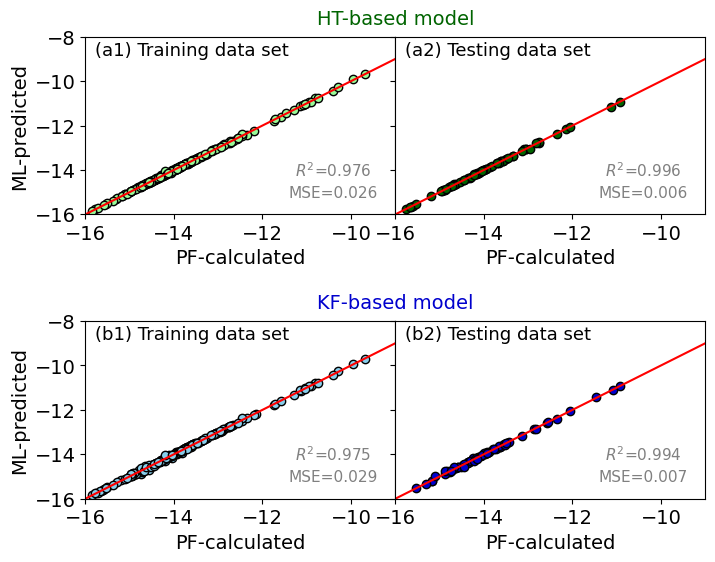

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6),sharey=True)
fig.subplots_adjust(wspace=0 , hspace=0.6)

plt.rc('font', size=14)


axes[0,0].scatter(y_train_ht,predictions_ht_train_DT,edgecolor="black",c="palegreen")
# Add a line for peDTect correlation
axes[0,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,0].set_xlabel("Calculated ln(PDAS)")
axes[0,0].set_ylabel("Predicted ln(PDAS)")
axes[0,0].set_ylim([-16,-8])
axes[0,0].set_xlim([-16,-9])
axes[0,0].set_title ("(a1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,0].text(1.0, 1.1, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")
axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_train_ht_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=11)
axes[0,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_train_ht_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=11)

axes[0,1].scatter(y_test_ht,predictions_ht_test_DT,edgecolor="black",c="darkgreen")
# Add a line for peDTect correlation
axes[0,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,1].set_xlabel("Calculated ln(PDAS)")
axes[0,1].set_ylim([-16,-8])
axes[0,1].set_xlim([-16,-9])
axes[0,1].set_title ("(a2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_ht_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=11)
axes[0,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_ht_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=11)



axes[1,0].scatter(y_train_kf,predictions_kf_train_DT,edgecolor="black",c="skyblue")
# Add a line for peDTect correlation
axes[1,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylabel("Predicted ln(PDAS)")
axes[1,0].set_ylim([-16,-8])
axes[1,0].set_xlim([-16,-9])
axes[1,0].set_title ("(b1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,0].text(1.0, 1.1, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="mediumblue")
axes[1,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_train_kf_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=11)
axes[1,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_train_kf_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=11)


axes[1,1].scatter(y_test_kf,predictions_kf_test_DT,edgecolor="black",c="mediumblue")
# Add a line for peDTect correlation
axes[1,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,1].set_xlabel("Calculated ln(PDAS)")
#axes[1,1].set_ylabel ("ML-predicted")
axes[1,1].set_ylim([-16,-8])
axes[1,1].set_xlim([-16,-9])
axes[1,1].set_title ("(b2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_kf_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=11)
axes[1,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_kf_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=11)
fig.savefig('../Figure_new/predict_calculate_DT.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')
#plt.close(fig)

## 2.3 Ranfom Forest

### 2.3.1 HT model

In [61]:
n_estimators = range(1, 10, 3)
max_depth=range(1, 15, 2)
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_2_gs_ht = RandomForestRegressor()

# Perform grid search
gs_ht = GridSearchCV(model_2_gs_ht, random_grid, cv=kf)
gs_ht.fit(x_train_ht, y_train_ht.values.ravel())

# Perform cross-validation and collect results
cv_result_ht = cross_validate(gs_ht, x_ht, y_ht, cv=kf, return_estimator=True)
scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring='neg_mean_squared_error')
MSF_ht_RF=abs(scores.mean())
print(f"Smallest Mean Squared Error: {MSF_ht_RF}")

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_ht['estimator'][best_index]
best_params = best_estimator.best_params_

print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {scores}")
n_estimators_ht_op=best_params['n_estimators']
max_depth_ht_op=best_params['max_depth']
bootstrap_ht_op=best_params['bootstrap']

scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf,scoring='r2')
r2_ht_RF=abs(scores.mean())

print(f"R2: {r2_ht_RF}")

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

Smallest Mean Squared Error: 0.027654456626744643
Best Grid Search Setup: {'bootstrap': True, 'max_depth': 11, 'n_estimators': 7}
Smallest Mean Squared Error: [-0.01646996 -0.03166779 -0.03260857 -0.03039551 -0.01933952 -0.01493393
 -0.01171833 -0.02303831 -0.06765815 -0.02871448]
R2: 0.9715380707472757


In [86]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_2_ht = RandomForestRegressor(n_estimators=n_estimators_ht_op,max_depth=max_depth_ht_op,bootstrap=bootstrap_ht_op)
cv_result_ht=cross_validate(model_2_ht,x_ht,y_ht,cv=kf,return_estimator=True)
scores= cross_val_score(model_2_ht, x_ht, y_ht, cv=kf, scoring='neg_mean_squared_error')
pred_test_ht_RF = np.zeros((num_split, x_test_ht.shape[0]))
pred_train_ht_RF = np.zeros((num_split, x_train_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_test_ht_RF[i, :] = estimator.predict(x_test_ht).flatten()
    pred_train_ht_RF[i, :] = estimator.predict(x_train_ht).flatten()

# Average predictions across all folds
predictions_ht_test_RF = np.mean(pred_test_ht_RF, axis=0)
predictions_ht_train_RF = np.mean(pred_train_ht_RF, axis=0)

scores= cross_validate(model_2_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
RMSE_train_ht_RF=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
RMSE_test_ht_RF=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {RMSE_test_ht_RF}")
r2_train_ht_RF=round(np.mean(np.abs(scores['test_r2'])),3)
r2_test_ht_RF=round(np.mean(np.abs(scores['train_r2'])),3)


C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

Smallest Mean Squared Error for test: 0.005


### 2.3.2 KF model

In [62]:
n_estimators = range(1, 10, 3)
max_depth=range(1, 15, 2)
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_2_gs_kf = RandomForestRegressor()

# Perform grid search
gs_kf = GridSearchCV(model_2_gs_kf, random_grid, cv=kf)
gs_kf.fit(x_train_kf, y_train_kf.values.ravel())

# Perform cross-validation and collect results
cv_result_kf = cross_validate(gs_kf, x_kf, y_kf, cv=kf, return_estimator=True)
scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='neg_mean_squared_error')
MSF_kf_RF=abs(scores.mean())
print(f"Smallest Mean Squared Error: {MSF_kf_RF}")


# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_kf['estimator'][best_index]
best_params = best_estimator.best_params_

print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {scores}")
n_estimators_kf_op=best_params['n_estimators']
max_depth_kf_op=best_params['max_depth']
bootstrap_kf_op=best_params['bootstrap']

scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='r2')
r2_kf_RF=abs(scores.mean())

print(f"R2: {r2_kf_RF}")

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

Smallest Mean Squared Error: 0.037388423181166815
Best Grid Search Setup: {'bootstrap': True, 'max_depth': 9, 'n_estimators': 7}
Smallest Mean Squared Error: [-0.03263207 -0.02698625 -0.02460278 -0.0331452  -0.02096743 -0.01957367
 -0.01634359 -0.03829246 -0.12993043 -0.03141036]
R2: 0.9671283695411936


In [87]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_2_kf = RandomForestRegressor(n_estimators=n_estimators_kf_op,max_depth=max_depth_kf_op,bootstrap=bootstrap_kf_op)
cv_result_kf=cross_validate(model_2_kf,x_kf,y_kf,cv=kf,return_estimator=True)
scores= cross_val_score(model_2_kf, x_kf, y_kf, cv=kf, scoring='neg_mean_squared_error')
pred_test_kf_RF = np.zeros((num_split, x_test_kf.shape[0]))
pred_train_kf_RF = np.zeros((num_split, x_train_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_test_kf_RF[i, :] = estimator.predict(x_test_kf).flatten()
    pred_train_kf_RF[i, :] = estimator.predict(x_train_kf).flatten()

# Average predictions across all folds
predictions_kf_test_RF = np.mean(pred_test_kf_RF, axis=0)
predictions_kf_train_RF = np.mean(pred_train_kf_RF, axis=0)

scores= cross_validate(model_2_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
RMSE_train_kf_RF=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
RMSE_test_kf_RF=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {RMSE_test_kf_RF}")
r2_train_kf_RF=round(np.mean(np.abs(scores['test_r2'])),3)
r2_test_kf_RF=round(np.mean(np.abs(scores['train_r2'])),3)


C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

Smallest Mean Squared Error for test: 0.008


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6),sharey=True)
fig.subplots_adjust(wspace=0 , hspace=0.6)

plt.rc('font', size=14)


axes[0,0].scatter(y_train_ht,predictions_ht_train_RF,edgecolor="black",c="palegreen")
# Add a line for perfect correlation
axes[0,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,0].set_xlabel("Calculated ln(PDAS)")
axes[0,0].set_ylabel("Predicted ln(PDAS)")
axes[0,0].set_ylim([-16,-8])
axes[0,0].set_xlim([-16,-9])
axes[0,0].set_title ("(a1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,0].text(1.0, 1.1, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")
axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_train_ht_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=11)
axes[0,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_train_ht_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=11)

axes[0,1].scatter(y_test_ht,predictions_ht_test_RF,edgecolor="black",c="darkgreen")
# Add a line for perfect correlation
axes[0,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,1].set_xlabel("Calculated ln(PDAS)")
axes[0,1].set_ylim([-16,-8])
axes[0,1].set_xlim([-16,-9])
axes[0,1].set_title ("(a2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_ht_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=11)
axes[0,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_ht_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=11)



axes[1,0].scatter(y_train_kf,predictions_kf_train_RF,edgecolor="black",c="skyblue")
# Add a line for perfect correlation
axes[1,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylabel("Predicted ln(PDAS)")
axes[1,0].set_ylim([-16,-8])
axes[1,0].set_xlim([-16,-9])
axes[1,0].set_title ("(b1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,0].text(1.0, 1.1, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="mediumblue")
axes[1,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_train_kf_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=11)
axes[1,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_train_kf_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=11)


axes[1,1].scatter(y_test_kf,predictions_kf_test_RF,edgecolor="black",c="mediumblue")
# Add a line for perfect correlation
axes[1,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,1].set_xlabel("Calculated ln(PDAS)")
#axes[1,1].set_ylabel ("ML-predicted")
axes[1,1].set_ylim([-16,-8])
axes[1,1].set_xlim([-16,-9])
axes[1,1].set_title ("(b2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_kf_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=11)
axes[1,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_kf_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=11)
fig.savefig('../Figure_new/predict_calculate_RF.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')
plt.close(fig)

## 2.4 GradientBoostingRegressor

### 2.4.1 HT model

In [90]:
learning_rate = [i/10.0 for i in range(0,4)]
max_depth=range(1, 6, 2)
n_estimators=range(50,651,150)
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 5
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_8_gs_ht =GradientBoostingRegressor()

gs_ht = GridSearchCV(model_8_gs_ht, random_grid, cv=kf)
gs_ht.fit(x_train_ht, y_train_ht.values.ravel())

# Perform cross-validation and collect results
cv_result_ht = cross_validate(gs_ht, x_ht, y_ht, cv=kf, return_estimator=True)
scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring='neg_mean_squared_error')
MSF_ht_XGB=abs(scores.mean())
print(f"Smallest Mean Squared Error: {MSF_ht_XGB}")

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_ht['estimator'][best_index]
best_params = best_estimator.best_params_

print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {scores}")
n_estimators_ht_op=best_params['n_estimators']
max_depth_ht_op=best_params['max_depth']
learning_rate_ht_op=best_params['learning_rate']

scores = cross_val_score(gs_ht, x_ht, y_ht.values.ravel(), cv=kf,scoring='r2')
r2_ht_XGB=abs(scores.mean())

print(f"R2: {r2_ht_XGB}")

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Smallest Mean Squared Error: 0.01179653077298513
Best Grid Search Setup: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500}
Smallest Mean Squared Error: [-0.00823553 -0.0136561  -0.00953462 -0.0120225  -0.01553391]
R2: 0.9896454923001045


In [91]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_8_ht = GradientBoostingRegressor(n_estimators=n_estimators_ht_op,max_depth=max_depth_ht_op,learning_rate=learning_rate_ht_op)
cv_result_ht=cross_validate(model_8_ht,x_ht,y_ht,cv=kf,return_estimator=True)
scores= cross_val_score(model_8_ht, x_ht, y_ht, cv=kf, scoring='neg_mean_squared_error')
pred_test_ht_XGB = np.zeros((num_split, x_test_ht.shape[0]))
pred_train_ht_XGB = np.zeros((num_split, x_train_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_test_ht_XGB[i, :] = estimator.predict(x_test_ht).flatten()
    pred_train_ht_XGB[i, :] = estimator.predict(x_train_ht).flatten()

# Average predictions across all folds
predictions_ht_test_XGB = np.mean(pred_test_ht_XGB, axis=0)
predictions_ht_train_XGB = np.mean(pred_train_ht_XGB, axis=0)

scores= cross_validate(model_8_ht, x_ht, y_ht.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
RMSE_train_ht_XGB=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
RMSE_test_ht_XGB=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {RMSE_test_ht_XGB}")
r2_train_ht_XGB=round(np.mean(np.abs(scores['test_r2'])),3)
r2_test_ht_XGB=round(np.mean(np.abs(scores['train_r2'])),3)


C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Smallest Mean Squared Error for test: 0.005


### 2.4.2 KF model

In [92]:
learning_rate = [i/10.0 for i in range(0,4)]
max_depth=range(1, 8, 3)
n_estimators=range(50,851,200)
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth}#,
              # 'min_samples_leaf': min_samples_leaf}
num_split = 10
kf = KFold(n_splits=num_split, shuffle=True, random_state=42)
model_8_gs_kf =GradientBoostingRegressor()

gs_kf = GridSearchCV(model_8_gs_kf, random_grid, cv=kf,n_jobs=-1)
gs_kf.fit(x_train_kf, y_train_kf.values.ravel())

# Perform cross-validation and collect results
cv_result_kf = cross_validate(gs_kf, x_kf, y_kf, cv=kf, return_estimator=True)
scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring='neg_mean_squared_error')
MSF_kf_XGB=abs(scores.mean())
print(f"Smallest Mean Squared Error: {MSF_kf_XGB}")

# Identify the setup that led to the smallest mean squared error
best_index = np.argmin(scores)
best_estimator = cv_result_kf['estimator'][best_index]
best_params = best_estimator.best_params_

print(f"Best Grid Search Setup: {best_params}")
print(f"Smallest Mean Squared Error: {scores}")
n_estimators_kf_op=best_params['n_estimators']
max_depth_kf_op=best_params['max_depth']
learning_rate_kf_op=best_params['learning_rate']

scores = cross_val_score(gs_kf, x_kf, y_kf.values.ravel(), cv=kf,scoring='r2')
r2_kf_XGB=abs(scores.mean())

print(f"R2: {r2_kf_XGB}")

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Smallest Mean Squared Error: 0.01521945948895231
Best Grid Search Setup: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 850}
Smallest Mean Squared Error: [-0.00575123 -0.02295118 -0.01549788 -0.00991401 -0.01286516 -0.01108713
 -0.00396723 -0.01813491 -0.03875882 -0.01326705]
R2: 0.9856696946642755


In [93]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_8_kf = GradientBoostingRegressor(n_estimators=n_estimators_kf_op,max_depth=max_depth_kf_op,learning_rate=learning_rate_kf_op)
cv_result_kf=cross_validate(model_8_kf,x_kf,y_kf,cv=kf,return_estimator=True)
scores= cross_val_score(model_8_kf, x_kf, y_kf, cv=kf, scoring='neg_mean_squared_error')
pred_test_kf_XGB = np.zeros((num_split, x_test_kf.shape[0]))
pred_train_kf_XGB = np.zeros((num_split, x_train_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_test_kf_XGB[i, :] = estimator.predict(x_test_kf).flatten()
    pred_train_kf_XGB[i, :] = estimator.predict(x_train_kf).flatten()

# Average predictions across all folds
predictions_kf_test_XGB = np.mean(pred_test_kf_XGB, axis=0)
predictions_kf_train_XGB = np.mean(pred_train_kf_XGB, axis=0)

scores= cross_validate(model_8_kf, x_kf, y_kf.values.ravel(), cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=True)
RMSE_train_kf_XGB=round(np.mean(np.abs(scores['test_neg_mean_squared_error'])),3)
RMSE_test_kf_XGB=round(np.mean(np.abs(scores['train_neg_mean_squared_error'])),3)

print(f"Smallest Mean Squared Error for test: {RMSE_test_kf_XGB}")
r2_train_kf_XGB=round(np.mean(np.abs(scores['test_r2'])),3)
r2_test_kf_XGB=round(np.mean(np.abs(scores['train_r2'])),3)


C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Smallest Mean Squared Error for test: 0.008


In [94]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6),sharey=True)
fig.subplots_adjust(wspace=0 , hspace=0.6)

plt.rc('font', size=14)


axes[0,0].scatter(y_train_ht,predictions_ht_train_XGB,edgecolor="black",c="palegreen")
# Add a line for peXGBect correlation
axes[0,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,0].set_xlabel("Calculated ln(PDAS)")
axes[0,0].set_ylabel("Predicted ln(PDAS)")
axes[0,0].set_ylim([-16,-8])
axes[0,0].set_xlim([-16,-9])
axes[0,0].set_title ("(a1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,0].text(1.0, 1.1, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")
axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_train_ht_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=11)
axes[0,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_train_ht_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=11)

axes[0,1].scatter(y_test_ht,predictions_ht_test_XGB,edgecolor="black",c="darkgreen")
# Add a line for peXGBect correlation
axes[0,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,1].set_xlabel("Calculated ln(PDAS)")
axes[0,1].set_ylim([-16,-8])
axes[0,1].set_xlim([-16,-9])
axes[0,1].set_title ("(a2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_ht_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=11)
axes[0,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_ht_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=11)



axes[1,0].scatter(y_train_kf,predictions_kf_train_XGB,edgecolor="black",c="skyblue")
# Add a line for peXGBect correlation
axes[1,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_xlabel("Calculated ln(PDAS)")
axes[1,0].set_ylabel("Predicted ln(PDAS)")
axes[1,0].set_ylim([-16,-8])
axes[1,0].set_xlim([-16,-9])
axes[1,0].set_title ("(b1) Training data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,0].text(1.0, 1.1, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="mediumblue")
axes[1,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_train_kf_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=11)
axes[1,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_train_kf_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=11)


axes[1,1].scatter(y_test_kf,predictions_kf_test_XGB,edgecolor="black",c="mediumblue")
# Add a line for peXGBect correlation
axes[1,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,1].set_xlabel("Calculated ln(PDAS)")
#axes[1,1].set_ylabel ("ML-predicted")
axes[1,1].set_ylim([-16,-8])
axes[1,1].set_xlim([-16,-9])
axes[1,1].set_title ("(b2) Testing data set",size=13,y=0.85,loc="left",x=0.03)
axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_kf_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=11)
axes[1,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_kf_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=11)
fig.savefig('../Figure_new/predict_calculate_XGB.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')
plt.close(fig)

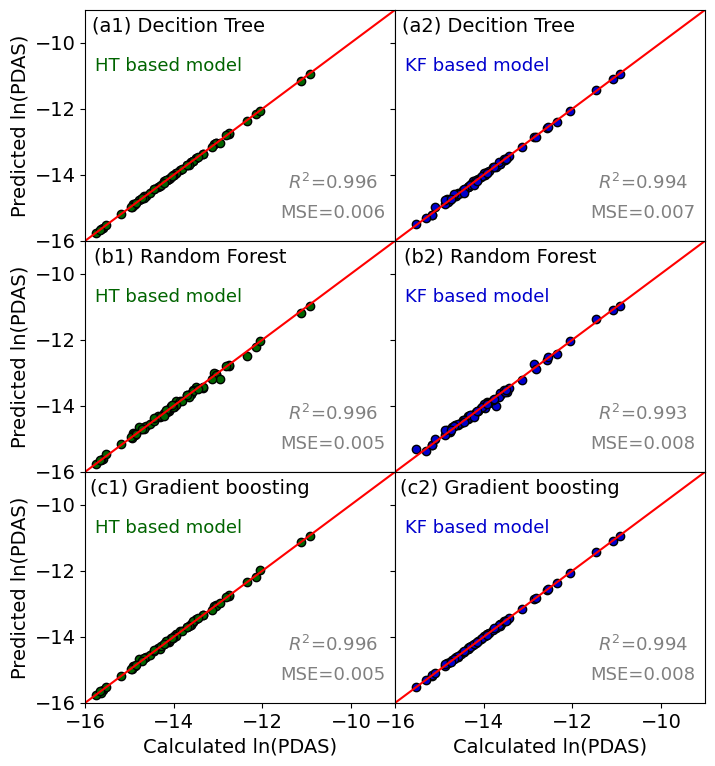

In [98]:
fig, axes = plt.subplots(3,2, figsize=(8, 9),sharey=True,sharex=True)
fig.subplots_adjust(wspace=0 , hspace=0)

plt.rc('font', size=14)


axes[0,0].scatter(y_test_ht,predictions_ht_test_DT,edgecolor="black",c="darkgreen")
# Add a line for perfect correlation
axes[0,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[0,0].set_xlabel("Calculated ln(PDAS)")
axes[0,0].set_ylabel("Predicted ln(PDAS)")

axes[0,0].set_ylim([-16,-9])
axes[0,0].set_xlim([-16,-9])
axes[0,0].text(0.3, 0.93, "(a1) Decition Tree", horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes)
axes[0,0].set_title ("HT based model",size=13,y=0.7,loc="left",x=0.03,c="darkgreen")
axes[0,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_ht_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)
axes[0,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_ht_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="grey",size=13)


axes[0,1].scatter(y_test_kf,predictions_kf_test_DT,edgecolor="black",c="mediumblue")
# Add a line for perfect correlation
axes[0,1].plot([-16,-9],[-16,-9],marker="None",color="red")
#axes[0,1].set_xlabel("Calculated ln(PDAS)")
axes[0,1].set_ylim([-16,-9])
axes[0,1].set_xlim([-16,-9])
axes[0,1].text(0.3, 0.93, "(a2) Decition Tree", horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes)
axes[0,1].set_title ("KF based model",size=13,y=0.7,loc="left",x=0.03,c="mediumblue")
axes[0,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_kf_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)
axes[0,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_kf_DT,3)), horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="grey",size=13)


axes[1,0].scatter(y_test_ht,predictions_ht_test_RF,edgecolor="black",c="darkgreen")
# Add a line for perfect correlation
axes[1,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[1,0].set_ylabel("Predicted ln(PDAS)")
axes[1,0].set_ylim([-16,-9])
axes[1,0].set_xlim([-16,-9])
axes[1,0].text(0.34, 0.93, "(b1) Random Forest", horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes)
axes[1,0].set_title ("HT based model",size=13,y=0.7,loc="left",x=0.03,c="darkgreen")
axes[1,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_ht_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)
axes[1,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_ht_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="grey",size=13)


axes[1,1].scatter(y_test_kf,predictions_kf_test_RF,edgecolor="black",c="mediumblue")
# Add a line for perfect correlation
axes[1,1].plot([-16,-9],[-16,-9],marker="None",color="red")
#axes[1,1].set_xlabel("Calculated ln(PDAS)")
axes[1,1].set_ylim([-16,-9])
axes[1,1].set_xlim([-16,-9])
axes[1,1].text(0.34, 0.93, "(b2) Random Forest", horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes)
axes[1,1].set_title ("KF based model",size=13,y=0.7,loc="left",x=0.03,c="mediumblue")
axes[1,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_kf_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)
axes[1,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_kf_RF,3)), horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="grey",size=13)

axes[2,0].scatter(y_test_ht,predictions_ht_test_XGB,edgecolor="black",c="darkgreen")
# Add a line for peXGBect correlation
axes[2,0].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[2,0].set_ylabel("Predicted ln(PDAS)")
axes[2,0].set_xlabel("Calculated ln(PDAS)")
axes[2,0].set_ylim([-16,-9])
axes[2,0].set_xlim([-16,-9])
axes[2,0].text(0.37, 0.93, "(c1) Gradient boosting", horizontalalignment='center', verticalalignment='center', transform=axes[2,0].transAxes)
axes[2,0].set_title ("HT based model",size=13,y=0.7,loc="left",x=0.03,c="darkgreen")
axes[2,0].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_ht_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[2,0].transAxes,c="grey",size=13)
axes[2,0].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_ht_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[2,0].transAxes,c="grey",size=13)


axes[2,1].scatter(y_test_kf,predictions_kf_test_XGB,edgecolor="black",c="mediumblue")
# Add a line for peXGBect correlation
axes[2,1].plot([-16,-9],[-16,-9],marker="None",color="red")
axes[2,1].set_xlabel("Calculated ln(PDAS)")
axes[2,1].set_ylim([-16,-9])
axes[2,1].set_xlim([-16,-9])
axes[2,1].text(0.37, 0.93, "(c2) Gradient boosting", horizontalalignment='center', verticalalignment='center', transform=axes[2,1].transAxes)
axes[2,1].set_title ("KF based model",size=13,y=0.7,loc="left",x=0.03,c="mediumblue")
axes[2,1].text(0.8, 0.25, r'$R^{2}$='+str(round(r2_test_kf_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[2,1].transAxes,c="grey",size=13)
axes[2,1].text(0.8, 0.12, 'MSE='+str(round(RMSE_test_kf_XGB,3)), horizontalalignment='center', verticalalignment='center', transform=axes[2,1].transAxes,c="grey",size=13)

fig.savefig('../Figure_new/nonparametrix_test.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')


## All Optimized Model's Performance

In [103]:
print('LR ht-based model: MSE={} and r2={}'.format(round(MSE_ht_test_LR,3),round(r2_ht_test_LR,3)))
print('LR kf-based model: MSE={} and r2={}'.format(round(MSE_kf_test_LR,3),round(r2_kf_test_LR,3)))
print('RR ht-based model: MSE={} and r2={}'.format(round(MSE_ht_test_RR,3),round(r2_ht_test_RR,3)))
print('RR kf-based model: MSE={} and r2={}'.format(round(MSE_kf_test_RR,3),round(r2_kf_test_RR,3)))
print('LaR ht-based model: MSE={} and r2={}'.format(round(MSE_ht_test_LaR,3),round(r2_ht_test_LaR,3)))
print('LaR kf-based model: MSE={} and r2={}'.format(round(MSE_kf_test_LaR,3),round(r2_kf_test_LaR,3)))      
print('DT ht-based model: MSE={} and r2={}'.format(round(RMSE_test_ht_DT,3),round(r2_test_ht_DT,3)))
print('DT kf-based model: MSE={} and r2={}'.format(round(RMSE_test_kf_DT,3),round(r2_test_kf_DT,3)))
print('RF ht-based model: MSE={} and r2={}'.format(round(RMSE_test_ht_RF,3),round(r2_test_ht_RF,3)))
print('RF kf-based model: MSE={} and r2={}'.format(round(RMSE_test_kf_RF,3),round(r2_test_kf_RF,3)))
print('XGB ht-based model: MSE={} and r2={}'.format(round(RMSE_test_ht_XGB,3),round(r2_test_ht_XGB,3)))
print('XGB kf-based model: MSE={} and r2={}'.format(round(RMSE_test_kf_XGB,3),round(r2_test_kf_XGB,3)))

LR ht-based model: MSE=0.141 and r2=0.87
LR kf-based model: MSE=0.156 and r2=0.855
RR ht-based model: MSE=0.141 and r2=0.87
RR kf-based model: MSE=0.156 and r2=0.855
LaR ht-based model: MSE=0.141 and r2=0.87
LaR kf-based model: MSE=0.156 and r2=0.855
DT ht-based model: MSE=0.006 and r2=0.996
DT kf-based model: MSE=0.007 and r2=0.994
RF ht-based model: MSE=0.005 and r2=0.996
RF kf-based model: MSE=0.008 and r2=0.993
XGB ht-based model: MSE=0.005 and r2=0.996
XGB kf-based model: MSE=0.008 and r2=0.994


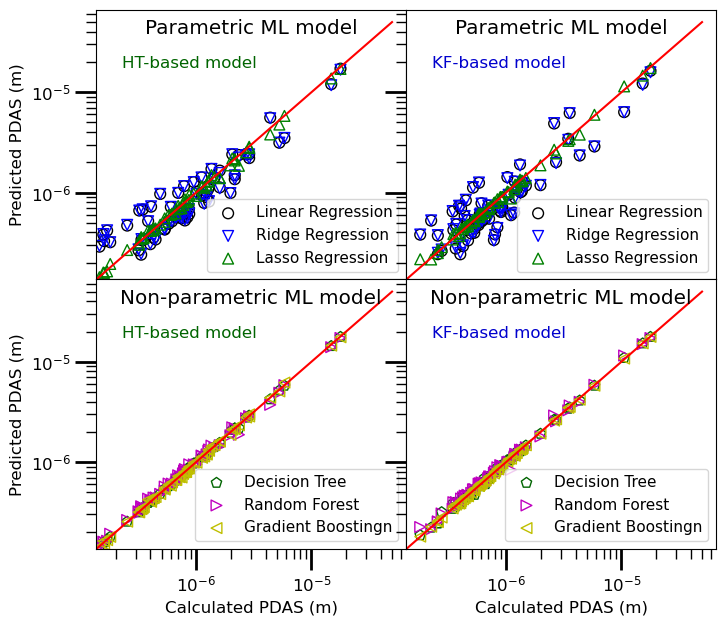

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7),sharey=True,sharex=True)
fig.subplots_adjust(wspace=0 , hspace=0.0)
plt.rc('font', size=12)


axes[0,0].scatter(np.exp(y_test_ht), np.exp(predictions_test_ht_LR), marker="o", s=60, facecolors='none', edgecolors='k', label="Linear Regression")
# Add a line for peDTect correlation
axes[0,0].scatter(np.exp(y_test_ht), np.exp(predictions_test_ht_RR), marker="v", s=60, facecolors='none', edgecolors='b', label="Ridge Regression")
axes[0,0].scatter(np.exp(y_test_ht), np.exp(predictions_test_ht_LaR), marker="^", s=60, facecolors='none', edgecolors='g', label="Lasso Regression")
axes[0,0].plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axes[0,0].set_xscale("log")
axes[0,0].set_yscale("log")
axes[0,0].legend(loc="lower right",frameon=True,fontsize=11) #,
#axes[0,0].set_xlabel("Calculated PDAS(m)")
axes[0,0].set_ylabel("Predicted PDAS (m)")
axes[0,0].tick_params('both', length=15, width=2, which='major')
axes[0,0].tick_params('both', length=7, width=1, which='minor')
axes[0,0].set_title("Parametric ML model",y=0.88)
axes[0,0].text(0.3, 0.8, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")



axes[0,1].scatter(np.exp(y_test_kf), np.exp(predictions_test_kf_LR), marker="o", s=60, facecolors='none', edgecolors='k', label="Linear Regression")
# Add a line for peDTect correlation
axes[0,1].scatter(np.exp(y_test_kf), np.exp(predictions_test_kf_RR), marker="v", s=60, facecolors='none', edgecolors='b', label="Ridge Regression")
axes[0,1].scatter(np.exp(y_test_kf), np.exp(predictions_test_kf_LaR), marker="^", s=60, facecolors='none', edgecolors='g', label="Lasso Regression")
axes[0,1].plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axes[0,1].set_xscale("log")
axes[0,1].set_yscale("log")
axes[0,1].legend(loc="lower right",frameon=True,fontsize=11) #,
#axes[0,1].set_xlabel("Calculated PDAS(m)")
#axes[0,1].set_ylabel("Predicted PDAS (m)")
axes[0,1].tick_params('both', length=15, width=2, which='major')
axes[0,1].tick_params('both', length=7, width=1, which='minor')
axes[0,1].set_title("Parametric ML model",y=0.88)
axes[0,1].text(0.3, 0.8, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="mediumblue")

axes[1,0].scatter(np.exp(y_test_ht), np.exp(predictions_ht_test_DT), marker="p", s=60, facecolors='none', edgecolors='darkgreen', label="Decision Tree")
axes[1,0].scatter(np.exp(y_test_ht), np.exp(predictions_ht_test_RF), marker=">", s=60, facecolors='none', edgecolors='m', label="Random Forest")
axes[1,0].scatter(np.exp(y_test_ht), np.exp(predictions_ht_test_XGB), marker="<", s=60, facecolors='none', edgecolors='y', label="Gradient Boostingn")
axes[1,0].plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axes[1,0].set_xscale("log")
axes[1,0].set_yscale("log")
axes[1,0].legend(loc="lower right",frameon=True,fontsize=11) #,
#axes[1,0].set_xlabel("Calculated PDAS(m)")
axes[1,0].set_ylabel("Predicted PDAS (m)")
axes[1,0].set_xlabel("Calculated PDAS (m)")

axes[1,0].tick_params('both', length=15, width=2, which='major')
axes[1,0].tick_params('both', length=7, width=1, which='minor')
axes[1,0].set_title("Non-parametric ML model",y=0.88)
axes[1,0].text(0.3, 0.8, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="darkgreen")

axes[1,1].scatter(np.exp(y_test_kf), np.exp(predictions_kf_test_DT), marker="p", s=60, facecolors='none', edgecolors='darkgreen', label="Decision Tree")
axes[1,1].scatter(np.exp(y_test_kf), np.exp(predictions_kf_test_RF), marker=">", s=60, facecolors='none', edgecolors='m', label="Random Forest")
axes[1,1].scatter(np.exp(y_test_kf), np.exp(predictions_kf_test_XGB), marker="<", s=60, facecolors='none', edgecolors='y', label="Gradient Boostingn")
axes[1,1].plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axes[1,1].set_xscale("log")
axes[1,1].set_yscale("log")
axes[1,1].legend(loc="lower right",frameon=True,fontsize=11) #,
#axes[1,1].set_xlabel("Calculated PDAS(m)")
axes[1,1].set_xlabel("Calculated PDAS (m)")
axes[1,1].tick_params('both', length=15, width=2, which='major')
axes[1,1].tick_params('both', length=7, width=1, which='minor')
axes[1,1].set_title("Non-parametric ML model",y=0.88)
axes[1,1].text(0.3, 0.8, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="mediumblue")


fig.savefig('../Figure_new/all-parametric-nonparametric.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')
#plt.close(fig)

# 3. Experimental Validation

In [122]:
df_exp["ln(PDAS)"]=np.log(df_exp["PDAS"])
df_exp["ln(V)"]=np.log(df_exp["V"])
df_exp["ln(G)"]=np.log(df_exp["G"])
df_exp[r"ln($A_{HT}$)"]=np.log(df_exp["Mat_HB"])
df_exp[r"ln($A_{KF}$)"]=np.log(df_exp["Mat_KF"])
df_exp_ln=df_exp.drop(["PDAS","V","G","Mat_HB","Mat_KF"],axis=1)


In [123]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   V             26 non-null     float64
 1   G             26 non-null     float64
 2   Mat_HB        26 non-null     float64
 3   Mat_KF        26 non-null     float64
 4   PDAS          26 non-null     float64
 5   Alloy         26 non-null     object 
 6   ln(PDAS)      26 non-null     float64
 7   ln(V)         26 non-null     float64
 8   ln(G)         26 non-null     float64
 9   ln($A_{HT}$)  26 non-null     float64
 10  ln($A_{KF}$)  26 non-null     float64
dtypes: float64(10), object(1)
memory usage: 2.4+ KB


In [124]:
df_exp.isna().any()

V               False
G               False
Mat_HB          False
Mat_KF          False
PDAS            False
Alloy           False
ln(PDAS)        False
ln(V)           False
ln(G)           False
ln($A_{HT}$)    False
ln($A_{KF}$)    False
dtype: bool

In [125]:
alloy_exp=df_exp.Alloy.unique()
print(alloy_exp)

['INC718' 'Ti-48 at%Ni' 'SRR99 ']


In [127]:

#x=df_ln.drop(["ln(PDAS)",r"ln($A_{HT}$)", "Alloy"],axis=1)

#x=sm.add_constant(x)
#y=df[["ln(PDAS)"]]

# Split the data
#x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

x_exp_ht=df_exp_ln.drop(["ln(PDAS)",r"ln($A_{KF}$)","Alloy"],axis=1)
x_exp_ht=sm.add_constant(x_exp_ht)
y_exp_ht=df_exp_ln[["ln(PDAS)"]]

In [128]:

#x=df_ln.drop(["ln(PDAS)",r"ln($A_{HT}$)", "Alloy"],axis=1)

#x=sm.add_constant(x)
#y=df[["ln(PDAS)"]]

# Split the data
#x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

x_exp_kf=df_exp_ln.drop(["ln(PDAS)",r"ln($A_{HT}$)","Alloy"],axis=1)
x_exp_kf=sm.add_constant(x_exp_kf)
y_exp_kf=df_exp_ln[["ln(PDAS)"]]

## 3.1 Parametric Models

### 3.1.1 Linear Regression

In [131]:
cv_result_ht = cross_validate(rModel_ht_cv, x_ht, y_ht, cv=kf, return_estimator=True)
pred_exp_ht_LR = np.zeros((num_split, x_exp_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_exp_ht_LR[i, :] = estimator.predict(x_exp_ht).flatten()

# Average predictions across all folds
predictions_exp_ht_LR = np.mean(pred_exp_ht_LR, axis=0)

r2_exp_ht_LR=round(r2_score(y_exp_ht,predictions_exp_ht_LR),3)
MSE_exp_ht_LR=round(mean_squared_error(y_exp_ht,predictions_exp_ht_LR),3)


# Print R² scores statistics
print("The mean R² score  for _LR ht model for test is {}".format(r2_exp_ht_LR))
print("The mean MSE score  for _LR ht model for test is {}".format(MSE_exp_ht_LR))

cv_result_kf = cross_validate(rModel_kf_cv, x_kf, y_kf, cv=kf, return_estimator=True)
pred_exp_kf_LR = np.zeros((num_split, x_exp_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_exp_kf_LR[i, :] = estimator.predict(x_exp_kf).flatten()

# Average predictions across all folds
predictions_exp_kf_LR = np.mean(pred_exp_kf_LR, axis=0)

r2_exp_kf_LR=round(r2_score(y_exp_kf,predictions_exp_kf_LR),3)
MSE_exp_kf_LR=round(mean_squared_error(y_exp_kf,predictions_exp_kf_LR),3)


# Print R² scores statistics
print("The mean R² score for _LR kf model for test is {}".format(r2_exp_kf_LR))
print("The mean MSE score  for _LR kf model for test is {}".format(MSE_exp_kf_LR))

The mean R² score  for _LR ht model for test is 0.89
The mean MSE score  for _LR ht model for test is 0.151
The mean R² score for _LR kf model for test is 0.882
The mean MSE score  for _LR kf model for test is 0.163


### 3.1.2 Ridge Regression

In [132]:
cv_result_ht = cross_validate(model_4_ht, x_ht, y_ht, cv=kf, return_estimator=True)
pred_exp_ht_RR = np.zeros((num_split, x_exp_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_exp_ht_RR[i, :] = estimator.predict(x_exp_ht).flatten()

# Average predictions across all folds
predictions_exp_ht_RR = np.mean(pred_exp_ht_RR, axis=0)

r2_exp_ht_RR=round(r2_score(y_exp_ht,predictions_exp_ht_RR),3)
MSE_exp_ht_RR=round(mean_squared_error(y_exp_ht,predictions_exp_ht_RR),3)


# Print R² scores statistics
print("The mean R² score  for _RR ht model for test is {}".format(r2_exp_ht_RR))
print("The mean MSE score  for _RR ht model for test is {}".format(MSE_exp_ht_RR))

cv_result_kf = cross_validate(model_4_kf, x_kf, y_kf, cv=kf, return_estimator=True)
pred_exp_kf_RR = np.zeros((num_split, x_exp_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_exp_kf_RR[i, :] = estimator.predict(x_exp_kf).flatten()

# Average predictions across all folds
predictions_exp_kf_RR = np.mean(pred_exp_kf_RR, axis=0)

r2_exp_kf_RR=round(r2_score(y_exp_kf,predictions_exp_kf_RR),3)
MSE_exp_kf_RR=round(mean_squared_error(y_exp_kf,predictions_exp_kf_RR),3)


# Print R² scores statistics
print("The mean R² score for _RR kf model for test is {}".format(r2_exp_kf_RR))
print("The mean MSE score  for _RR kf model for test is {}".format(MSE_exp_kf_RR))

The mean R² score  for _RR ht model for test is 0.924
The mean MSE score  for _RR ht model for test is 0.104
The mean R² score for _RR kf model for test is 0.834
The mean MSE score  for _RR kf model for test is 0.229


### 3.1.3 Lasso Regression

In [133]:
cv_result_ht = cross_validate(model_4_ht, x_ht, y_ht, cv=kf, return_estimator=True)
pred_exp_ht_LaR = np.zeros((num_split, x_exp_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_exp_ht_LaR[i, :] = estimator.predict(x_exp_ht).flatten()

# Average predictions across all folds
predictions_exp_ht_LaR = np.mean(pred_exp_ht_LaR, axis=0)

r2_exp_ht_LaR=round(r2_score(y_exp_ht,predictions_exp_ht_LaR),3)
MSE_exp_ht_LaR=round(mean_squared_error(y_exp_ht,predictions_exp_ht_LaR),3)


# Print R² scores statistics
print("The mean R² score  for _LaR ht model for test is {}".format(r2_exp_ht_LaR))
print("The mean MSE score  for _LaR ht model for test is {}".format(MSE_exp_ht_LaR))

cv_result_kf = cross_validate(model_4_kf, x_kf, y_kf, cv=kf, return_estimator=True)
pred_exp_kf_LaR = np.zeros((num_split, x_exp_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_exp_kf_LaR[i, :] = estimator.predict(x_exp_kf).flatten()

# Average predictions across all folds
predictions_exp_kf_LaR = np.mean(pred_exp_kf_LaR, axis=0)

r2_exp_kf_LaR=round(r2_score(y_exp_kf,predictions_exp_kf_LaR),3)
MSE_exp_kf_LaR=round(mean_squared_error(y_exp_kf,predictions_exp_kf_LaR),3)


# Print R² scores statistics
print("The mean R² score for _LaR kf model for test is {}".format(r2_exp_kf_LaR))
print("The mean MSE score  for _LaR kf model for test is {}".format(MSE_exp_kf_LaR))

The mean R² score  for _LaR ht model for test is 0.924
The mean MSE score  for _LaR ht model for test is 0.104
The mean R² score for _LaR kf model for test is 0.834
The mean MSE score  for _LaR kf model for test is 0.229


## 3.2 Non-Parametric Models

### 3.2.1 Dicision Tree

In [134]:
cv_result_ht = cross_validate(model_1_ht, x_ht, y_ht, cv=kf, return_estimator=True)
pred_exp_ht_DT = np.zeros((num_split, x_exp_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_exp_ht_DT[i, :] = estimator.predict(x_exp_ht).flatten()

# Average predictions across all folds
predictions_exp_ht_DT = np.mean(pred_exp_ht_DT, axis=0)

r2_exp_ht_DT=round(r2_score(y_exp_ht,predictions_exp_ht_DT),3)
MSE_exp_ht_DT=round(mean_squared_error(y_exp_ht,predictions_exp_ht_DT),3)


# Print R² scores statistics
print("The mean R² score  for _DT ht model for test is {}".format(r2_exp_ht_DT))
print("The mean MSE score  for _DT ht model for test is {}".format(MSE_exp_ht_DT))

cv_result_kf = cross_validate(model_1_kf, x_kf, y_kf, cv=kf, return_estimator=True)
pred_exp_kf_DT = np.zeros((num_split, x_exp_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_exp_kf_DT[i, :] = estimator.predict(x_exp_kf).flatten()

# Average predictions across all folds
predictions_exp_kf_DT = np.mean(pred_exp_kf_DT, axis=0)

r2_exp_kf_DT=round(r2_score(y_exp_kf,predictions_exp_kf_DT),3)
MSE_exp_kf_DT=round(mean_squared_error(y_exp_kf,predictions_exp_kf_DT),3)


# Print R² scores statistics
print("The mean R² score for _DT kf model for test is {}".format(r2_exp_kf_DT))
print("The mean MSE score  for _DT kf model for test is {}".format(MSE_exp_kf_DT))

The mean R² score  for _DT ht model for test is 0.294
The mean MSE score  for _DT ht model for test is 0.971
The mean R² score for _DT kf model for test is -0.272
The mean MSE score  for _DT kf model for test is 1.75


### 3.2.2 Random Forest

In [136]:
cv_result_ht = cross_validate(model_2_ht, x_ht, y_ht, cv=kf, return_estimator=True)
pred_exp_ht_RF = np.zeros((num_split, x_exp_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_exp_ht_RF[i, :] = estimator.predict(x_exp_ht).flatten()

# Average predictions across all folds
predictions_exp_ht_RF = np.mean(pred_exp_ht_RF, axis=0)

r2_exp_ht_RF=round(r2_score(y_exp_ht,predictions_exp_ht_RF),3)
MSE_exp_ht_RF=round(mean_squared_error(y_exp_ht,predictions_exp_ht_RF),3)


# Print R² scores statistics
print("The mean R² score  for _RF ht model for test is {}".format(r2_exp_ht_RF))
print("The mean MSE score  for _RF ht model for test is {}".format(MSE_exp_ht_RF))

cv_result_kf = cross_validate(model_2_kf, x_kf, y_kf, cv=kf, return_estimator=True)
pred_exp_kf_RF = np.zeros((num_split, x_exp_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_exp_kf_RF[i, :] = estimator.predict(x_exp_kf).flatten()

# Average predictions across all folds
predictions_exp_kf_RF = np.mean(pred_exp_kf_RF, axis=0)

r2_exp_kf_RF=round(r2_score(y_exp_kf,predictions_exp_kf_RF),3)
MSE_exp_kf_RF=round(mean_squared_error(y_exp_kf,predictions_exp_kf_RF),3)


# Print R² scores statistics
print("The mean R² score for _RF kf model for test is {}".format(r2_exp_kf_RF))
print("The mean MSE score  for _RF kf model for test is {}".format(MSE_exp_kf_RF))

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

The mean R² score  for _RF ht model for test is 0.276
The mean MSE score  for _RF ht model for test is 0.995
The mean R² score for _RF kf model for test is -0.685
The mean MSE score  for _RF kf model for test is 2.318


C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

In [137]:
cv_result_ht = cross_validate(model_8_ht, x_ht, y_ht, cv=kf, return_estimator=True)
pred_exp_ht_XGB = np.zeros((num_split, x_exp_ht.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_ht['estimator']):
    pred_exp_ht_XGB[i, :] = estimator.predict(x_exp_ht).flatten()

# Average predictions across all folds
predictions_exp_ht_XGB = np.mean(pred_exp_ht_XGB, axis=0)

r2_exp_ht_XGB=round(r2_score(y_exp_ht,predictions_exp_ht_XGB),3)
MSE_exp_ht_XGB=round(mean_squared_error(y_exp_ht,predictions_exp_ht_XGB),3)


# Print R² scores statistics
print("The mean R² score  for _XGB ht model for test is {}".format(r2_exp_ht_XGB))
print("The mean MSE score  for _XGB ht model for test is {}".format(MSE_exp_ht_XGB))

cv_result_kf = cross_validate(model_8_kf, x_kf, y_kf, cv=kf, return_estimator=True)
pred_exp_kf_XGB = np.zeros((num_split, x_exp_kf.shape[0]))

# Collect predictions from each estimator
for i, estimator in enumerate(cv_result_kf['estimator']):
    pred_exp_kf_XGB[i, :] = estimator.predict(x_exp_kf).flatten()

# Average predictions across all folds
predictions_exp_kf_XGB = np.mean(pred_exp_kf_XGB, axis=0)

r2_exp_kf_XGB=round(r2_score(y_exp_kf,predictions_exp_kf_XGB),3)
MSE_exp_kf_XGB=round(mean_squared_error(y_exp_kf,predictions_exp_kf_XGB),3)


# Print R² scores statistics
print("The mean R² score for _XGB kf model for test is {}".format(r2_exp_kf_XGB))
print("The mean MSE score  for _XGB kf model for test is {}".format(MSE_exp_kf_XGB))

C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

The mean R² score  for _XGB ht model for test is 0.759
The mean MSE score  for _XGB ht model for test is 0.331


C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kavou\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

The mean R² score for _XGB kf model for test is -0.561
The mean MSE score  for _XGB kf model for test is 2.147


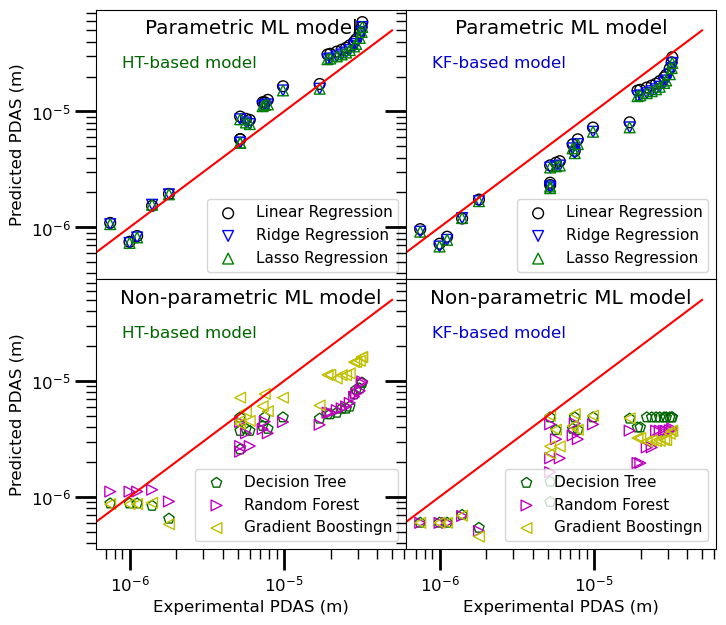

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7),sharey=True,sharex=True)
fig.subplots_adjust(wspace=0 , hspace=0.0)
plt.rc('font', size=12)

axes[0,0].scatter(np.exp(y_exp_ht), np.exp(predictions_exp_ht_LR), marker="o", s=60, facecolors='none', edgecolors='k', label="Linear Regression")
# Add a line for peDTect correlation
axes[0,0].scatter(np.exp(y_exp_ht), np.exp(predictions_exp_ht_RR), marker="v", s=60, facecolors='none', edgecolors='b', label="Ridge Regression")
axes[0,0].scatter(np.exp(y_exp_ht), np.exp(predictions_exp_ht_LaR), marker="^", s=60, facecolors='none', edgecolors='g', label="Lasso Regression")
axes[0,0].plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axes[0,0].set_xscale("log")
axes[0,0].set_yscale("log")
axes[0,0].legend(loc="lower right",frameon=True,fontsize=11) #,
#axes[0,0].set_xlabel("Experimental PDAS(m)")
axes[0,0].set_ylabel("Predicted PDAS (m)")
axes[0,0].tick_params('both', length=15, width=2, which='major')
axes[0,0].tick_params('both', length=7, width=1, which='minor')
axes[0,0].set_title("Parametric ML model",y=0.88)
axes[0,0].text(0.3, 0.8, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes,c="darkgreen")



axes[0,1].scatter(np.exp(y_exp_kf), np.exp(predictions_exp_kf_LR), marker="o", s=60, facecolors='none', edgecolors='k', label="Linear Regression")
# Add a line for peDTect correlation
axes[0,1].scatter(np.exp(y_exp_kf), np.exp(predictions_exp_kf_RR), marker="v", s=60, facecolors='none', edgecolors='b', label="Ridge Regression")
axes[0,1].scatter(np.exp(y_exp_kf), np.exp(predictions_exp_kf_LaR), marker="^", s=60, facecolors='none', edgecolors='g', label="Lasso Regression")
axes[0,1].plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axes[0,1].set_xscale("log")
axes[0,1].set_yscale("log")
axes[0,1].legend(loc="lower right",frameon=True,fontsize=11) #,
#axes[0,1].set_xlabel("Experimental PDAS(m)")
#axes[0,1].set_ylabel("Predicted PDAS (m)")
axes[0,1].tick_params('both', length=15, width=2, which='major')
axes[0,1].tick_params('both', length=7, width=1, which='minor')
axes[0,1].set_title("Parametric ML model",y=0.88)
axes[0,1].text(0.3, 0.8, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes,c="mediumblue")

axes[1,0].scatter(np.exp(y_exp_ht), np.exp(predictions_exp_ht_DT), marker="p", s=60, facecolors='none', edgecolors='darkgreen', label="Decision Tree")
axes[1,0].scatter(np.exp(y_exp_ht), np.exp(predictions_exp_ht_RF), marker=">", s=60, facecolors='none', edgecolors='m', label="Random Forest")
axes[1,0].scatter(np.exp(y_exp_ht), np.exp(predictions_exp_ht_XGB), marker="<", s=60, facecolors='none', edgecolors='y', label="Gradient Boostingn")
axes[1,0].plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axes[1,0].set_xscale("log")
axes[1,0].set_yscale("log")
axes[1,0].legend(loc="lower right",frameon=True,fontsize=11) #,
#axes[1,0].set_xlabel("Experimental PDAS(m)")
axes[1,0].set_ylabel("Predicted PDAS (m)")
axes[1,0].set_xlabel("Experimental PDAS (m)")

axes[1,0].tick_params('both', length=15, width=2, which='major')
axes[1,0].tick_params('both', length=7, width=1, which='minor')
axes[1,0].set_title("Non-parametric ML model",y=0.88)
axes[1,0].text(0.3, 0.8, 'HT-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes,c="darkgreen")

axes[1,1].scatter(np.exp(y_exp_kf), np.exp(predictions_exp_kf_DT), marker="p", s=60, facecolors='none', edgecolors='darkgreen', label="Decision Tree")
axes[1,1].scatter(np.exp(y_exp_kf), np.exp(predictions_exp_kf_RF), marker=">", s=60, facecolors='none', edgecolors='m', label="Random Forest")
axes[1,1].scatter(np.exp(y_exp_kf), np.exp(predictions_exp_kf_XGB), marker="<", s=60, facecolors='none', edgecolors='y', label="Gradient Boostingn")
axes[1,1].plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axes[1,1].set_xscale("log")
axes[1,1].set_yscale("log")
axes[1,1].legend(loc="lower right",frameon=True,fontsize=11) #,
#axes[1,1].set_xlabel("Experimental PDAS(m)")
axes[1,1].set_xlabel("Experimental PDAS (m)")
axes[1,1].tick_params('both', length=15, width=2, which='major')
axes[1,1].tick_params('both', length=7, width=1, which='minor')
axes[1,1].set_title("Non-parametric ML model",y=0.88)
axes[1,1].text(0.3, 0.8, 'KF-based model', horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes,c="mediumblue")


fig.savefig('../Figure_new/exp_validate.jpeg', facecolor="white",dpi=1200,bbox_inches='tight')
#plt.close(fig)

### Conclusions

1- We obtain a very important conclusion that in contract to analytical models, where temperature gradient plays much important role in the PDAS estimations, the velocity and temperature play almost equal roles in PDAS correlation!

2- In addition we compared different parametric and non parametric models. Despite the better performance of paranetric models 
on the computational data, when we compared them with the experimental predictions, they presented a much poorer performance and therefore, the parametric linear regression models works the best.

3- As we observed by the cross validation, the optimized alpha values for Ridge and Lasso regression models were very small. Therefore, we were already expecting the predictions of linear regression be close to Ridge and lasso models. As expected, the prediction of these models are very close to each other both for the experiment and computational data!